# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# base packages
import pandas as pd
import numpy as np
import sys

try:
    from StringIO import StringIO ## for Python 2
except ImportError:
    from io import StringIO ## for Python 3

from functools import reduce
from operator import concat

# classifier libraries
from sklearn.linear_model import LogisticRegression

# pipeline library
from sklearn.pipeline import Pipeline

# hyperparameter search library
from sklearn.model_selection import GridSearchCV

# train test split library
from sklearn.model_selection import train_test_split

# clustering libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score  # with it one can determine the optimal number of clusters

# library for sql queries
from sqlalchemy import create_engine

# visualization library
import matplotlib.pyplot as plt

# own library
from classifier_module import simplify_feature_values                   # transforner for simplifying values sets of profile variables
from classifier_module import add_viewing_pref_features                 # transformer for adding viewing preference variablea
from classifier_module import adjust_completion_feature                 # transformer for adding completion feature in no offers
from classifier_module import select_specific_offer_and_no_offer        # 
from classifier_module import promotion_classifier
from classifier_module import score_prom

# Section 1: Business understanding



Task 1: We want to find people who complete the considered offer if they receive it and would not complete the offer without receiving it

Task 2: We want to group the characteristics of customers' profiles and uniformity of these group of people

Task 3: We want to group the characteristics of **treated** customers' profiles and uniformity of these group of people

# Section 2: Data understanding

## 2.1 Gather data

In [2]:
# read in the json files
df_portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
df_profile = pd.read_json('data/profile.json', orient='records', lines=True)
df_transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2.2 Assess and preview data

In [3]:
# view all types of offers in the portfolio dataset
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# view profile
df_profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [5]:
# The events: 1. gender is null, 2. income is null and 3. age=118 appear always together? if these events when combined also fill up the same number of data-rows as each single event

print("Number of rows with 1. gender is null, 2. income is null and 3. age=118: ",df_profile[pd.isnull(df_profile["gender"]) & (df_profile.age==118) & pd.isnull(df_profile["income"])].shape[0])

for col in df_profile.columns:
    print("Number of Null values in column '" + col +"':",df_profile[pd.isnull(df_profile[col]) ].shape[0])

Number of rows with 1. gender is null, 2. income is null and 3. age=118:  2175
Number of Null values in column 'gender': 2175
Number of Null values in column 'age': 0
Number of Null values in column 'id': 0
Number of Null values in column 'became_member_on': 0
Number of Null values in column 'income': 2175


In [6]:
# view types of gender

df_profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [7]:
# view transcript dataset with two examples for each event type

indices=reduce(concat,list([list(df_transcript[df_transcript.event==i].iloc[0:2].index) for i in df_transcript.event.unique()]))
df_transcript.iloc[[i for i in indices]]


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0


In [8]:
# pick two individuals and plot their transaction records

df_transcript.groupby(by=["person", "time","event"]).first().tail(3545).head(45)

value
person                           time event                                                             
fcbcd28beee1457f8b3672658ea0a1e3 216  transaction                                       {'amount': 9.65}
                                 288  offer viewed      {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
                                 336  offer received    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
                                 348  offer viewed      {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
                                 366  transaction                                      {'amount': 17.85}
                                 378  transaction                                      {'amount': 23.81}
                                 408  offer received    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
                                 468  offer viewed      {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
                                 498  offer completed  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
                                      transaction                                      {'amount': 17.03}
                                 504  offer received    {'offer id': '3f207df678b143eea3cee63160fa8bed'}
                                      transaction                                      {'amount': 19.67}
                                 522  offer viewed      {'offer id': '3f207df678b143eea3cee63160fa8bed'}
                                 552  transaction                                      {'amount': 15.02}
                                 576  offer received    {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
                                 582  offer viewed      {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
                                 612  offer completed  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
                                      transaction                                       {'amount': 28.5}
                                 666  transaction                                      {'amount': 50.95}
fcbf38029321416f9e0c593b59c8ada7 0    offer received    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
                                      offer viewed      {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
                                 48   offer completed  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
                                      transaction                                      {'amount': 15.96}
                                 66   transaction                                      {'amount': 16.05}
                                 96   transaction                                      {'amount': 15.81}
                                 126  transaction                                      {'amount': 17.11}
                                 168  offer received    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
                                 174  offer completed  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
                                      transaction                                       {'amount': 11.3}
                                 204  transaction                                      {'amount': 11.65}
                                 264  transaction                                      {'amount': 21.74}
                                 270  transaction                                      {'amount': 11.73}
                                 336  offer received    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
                                      offer viewed      {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
                                 348  offer completed  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
                                      transaction                                      {'amount': 12.49}
                                 408  transaction                                       {'amount': 7.35}
    

In [9]:
# Determine maximum numbers of the event "offer received" for fixed person and time

max(df_transcript[df_transcript.event=="offer received"].groupby(by=["person", "time"]).count().reset_index().value)

1

If an advertisement is sent then only one per day!

In [10]:
# Can we have overlaping intervals of offers validities?

list(df_transcript.time[df_transcript.event=="offer received"].unique())

[0, 168, 336, 408, 504, 576]

All advertisements are sent at specific times. In between are long brakes, much longer than any offer is valid.

# Section 3: Prepare data

## 3.1 "df_profile" -> "df_profile_modified"

In [11]:
# create dummy columns for each gender "M", "F", "O"
df_profile_modified=pd.get_dummies(df_profile,columns=["gender"],dummy_na=True)

# replace all null values with 0' (affects income column only)
df_profile_modified.fillna(-10000,inplace=True)

# view
df_profile_modified.head(8)

,age,id,became_member_on,income,gender_F,gender_M,gender_O,gender_nan
0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,-10000.0,False,False,False,True
1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,True,False,False,False
2,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,-10000.0,False,False,False,True
3,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,True,False,False,False
4,118,a03223e636434f42ac4c3df47e8bac43,20170804,-10000.0,False,False,False,True
5,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,False,True,False,False
6,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,-10000.0,False,False,False,True
7,118,68617ca6246f4fbc85e91a2a49552598,20171002,-10000.0,False,False,False,True


## 3.2 "df_transcript", "df_portfolio" -> "df_transcript_unfolded_portfolio"

In [12]:
# unfold the dict 'value' in dataframe "transcript"

def equalize_offer_id_attributes(x_dict): 
    """ function to turn dict key name "offer id" into "offer_id" """
    key_list=x_dict.keys()
    if "offer id" in key_list:
        x_dict["offer_id"]=x_dict["offer id"]
        del x_dict["offer id"]
    return x_dict

def drop_redundant_reward_attribute(x_dict): 
    """ function to drop key name reward """
    key_list=x_dict.keys()

    if "reward" in key_list:
        del x_dict["reward"]
    return x_dict


# unfold attribute "value" in dataframe "transcript" and clean and save as "transcript_unfolded"
df_transcript_unfolded=pd.concat([df_transcript.drop(['value'], axis=1), df_transcript['value'].apply(equalize_offer_id_attributes).apply(drop_redundant_reward_attribute).apply(pd.Series)], axis=1)


# merge unfolded dataframe "transcript_unfolded" with "portfolio"
df_transcript_unfolded_portfolio=pd.merge(df_transcript_unfolded,df_portfolio,left_on="offer_id",right_on="id",how="left")
del df_transcript_unfolded_portfolio["id"]


# view new dataframe "transcript_unfolded_portfolio"
df_transcript_unfolded_portfolio.groupby(by=["person", "time","event", "offer_id"], dropna=False).first().head(35)

amount  \
person                           time event           offer_id                                   
0009655768c64bdeb2e877511632db8f 168  offer received  5a8bc65990b245e5a138643cd4eb9837     NaN   
                                 192  offer viewed    5a8bc65990b245e5a138643cd4eb9837     NaN   
                                 228  transaction     NaN                                22.16   
                                 336  offer received  3f207df678b143eea3cee63160fa8bed     NaN   
                                 372  offer viewed    3f207df678b143eea3cee63160fa8bed     NaN   
                                 408  offer received  f19421c1d4aa40978ebb69ca19b0e20d     NaN   
                                 414  offer completed f19421c1d4aa40978ebb69ca19b0e20d     NaN   
                                      transaction     NaN                                 8.57   
                                 456  offer viewed    f19421c1d4aa40978ebb69ca19b0e20d     NaN   
                                 504  offer received  fafdcd668e3743c1bb461111dcafc2a4     NaN   
                                 528  offer completed fafdcd668e3743c1bb461111dcafc2a4     NaN   
                                      transaction     NaN                                14.11   
                                 540  offer viewed    fafdcd668e3743c1bb461111dcafc2a4     NaN   
                                 552  transaction     NaN                                13.56   
                                 576  offer completed 2906b810c7d4411798c6938adc9daaa5     NaN   
                                      offer received  2906b810c7d4411798c6938adc9daaa5     NaN   
                                      transaction     NaN                                10.27   
                                 660  transaction     NaN                                12.36   
                                 690  transaction     NaN                                28.16   
                                 696  transaction     NaN                                18.41   
00116118485d4dfda04fdbaba9a87b5c 168  offer received  f19421c1d4aa40978ebb69ca19b0e20d     NaN   
                                 216  offer viewed    f19421c1d4aa40978ebb69ca19b0e20d     NaN   
                                 294  transaction     NaN                                 0.70   
                                 456  transaction     NaN                                 0.20   
                                 474  transaction     NaN                                 3.19   
                                 576  offer received  f19421c1d4aa40978ebb69ca19b0e20d     NaN   
                                 630  offer viewed    f19421c1d4aa40978ebb69ca19b0e20d     NaN   
0011e0d4e6b944f998e987f904e8c1e5 0    offer received  3f207df678b143eea3cee63160fa8bed     NaN   
                                 6    offer viewed    3f207df678b143eea3cee63160fa8bed     NaN   
                                 132  transaction     NaN                                13.49   
                                 168  offer received  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN   
                                 186  offer viewed    2298d6c36e964ae4a3e7e9706d1fb8c2     NaN   
                                 252  offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2     NaN   
                                      transaction     NaN                                11.93   
                                 336  offer received  5a8bc65990b245e5a138643cd4eb9837     NaN   

                                                                                        reward  \
person                           time event           offer_id                                   
0009655768c64bdeb2e877511632db8f 168  offer received  5a8bc65990b245e5a138643cd4eb9837     0.0   
                                 192  offer viewed    5a8bc65990b245e5a138643cd4eb9837     0.0   
                                 228  transaction     NaN            

## 3.3 "df_transcript_unfolded_portfolio" -> "df_main"

### 3.3.1 Calculate when offer is received, viewed, or completed

#### Create dataframe "df_when_received_when_viewed"

In [13]:
# create two versions of "transcript_unfolded_portfolio" - one with attribute "offer_received_time" and one with "offer_viewed_time"
tmp0=df_transcript_unfolded_portfolio[df_transcript_unfolded_portfolio.event=="offer received"][["person","offer_id","event", "duration","time"]].rename(columns={"time": "offer_received_time"})
tmp1=df_transcript_unfolded_portfolio[df_transcript_unfolded_portfolio.event=="offer viewed"][["person","offer_id","event","time"]].rename(columns={"time": "offer_viewed_time"})

# merge both upper dataframes for same events-type and sort out rows where not the exact offers lie are associated between left and right merge
tmp=pd.merge(tmp0,tmp1,on=["person", "offer_id"], how="left")
tmp=tmp[tmp.offer_received_time<=tmp.offer_viewed_time]
tmp=tmp.sort_values(by=["person", "offer_id", "offer_received_time", "offer_viewed_time"]).groupby(by=["person", "offer_id", "offer_received_time"]).first().reset_index().sort_values(by=["person", "offer_id", "offer_received_time", "offer_viewed_time"]).groupby(by=["person", "offer_viewed_time", "offer_id"]).last().reset_index()
tmp=tmp.drop(columns=["event_x","event_y"])

# add columns with nulls whenever offers are not viewed
df_when_received_when_viewed=pd.merge(tmp0,tmp,left_on=["person","offer_id","offer_received_time","duration"],right_on=["person", "offer_id", "offer_received_time","duration"],how="left").drop(columns="event")

# view new dataframe
df_when_received_when_viewed.head(12)

,person,offer_id,duration,offer_received_time,offer_viewed_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,6.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,6.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,7.0,0,18.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,10.0,0,12.0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,84.0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,0.0
6,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,0,24.0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,4.0,0,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,18.0
9,31dda685af34476cad5bc968bdb01c53,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,150.0


#### Create dataframe "df_when_received_when_completed"

In [14]:
# create two versions of "transcript_unfolded_portfolio" - one with attribute "offer_received_time" and one with "offer_viewed_time"
tmp0=df_transcript_unfolded_portfolio[df_transcript_unfolded_portfolio.event=="offer received"][["person","offer_id","event", "duration","time"]].rename(columns={"time": "offer_received_time"})
tmp1=df_transcript_unfolded_portfolio[df_transcript_unfolded_portfolio.event=="offer completed"][["person","offer_id","event","time"]].rename(columns={"time": "offer_completed_time"})

# merge both upper dataframes for same events-type and sort out rows where not the exact offers lie are associated between left and right merge
tmp=pd.merge(tmp0,tmp1,on=["person", "offer_id"], how="left")
tmp=tmp[tmp.offer_received_time<=tmp.offer_completed_time] # only select rows when offer completion time lies => offer receive time
tmp=tmp.sort_values(by=["person", "offer_id", "offer_received_time", "offer_completed_time"]).groupby(by=["person", "offer_id", "offer_received_time"]).first().reset_index().sort_values(by=["person", "offer_id", "offer_received_time", "offer_completed_time"]).groupby(by=["person", "offer_completed_time", "offer_id"]).last().reset_index()
tmp=tmp.drop(columns=["event_x","event_y"])

# add columns with nulls whenever offers are not completed
df_when_received_when_completed=pd.merge(tmp0,tmp,left_on=["person","offer_id","offer_received_time","duration"],right_on=["person", "offer_id", "offer_received_time","duration"],how="left").drop(columns="event")

# view new dataframe
df_when_received_when_completed.head(12)

,person,offer_id,duration,offer_received_time,offer_completed_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,132.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,7.0,0,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,10.0,0,NaN
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,NaN
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,60.0
6,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,0,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,4.0,0,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,NaN
9,31dda685af34476cad5bc968bdb01c53,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,NaN


#### Create dataframe "df_when_received_when_viewed_when_completed"

In [15]:
tmp=df_when_received_when_viewed.copy()
tmp["offer_completed_time"]=df_when_received_when_completed.offer_completed_time # merging is easy since the index is same between "df_when_received_when_viewed" and "df_when_received_when_completed"
df_when_received_when_viewed_when_completed=tmp

# view new dataframe
df_when_received_when_viewed_when_completed.head(12)

,person,offer_id,duration,offer_received_time,offer_viewed_time,offer_completed_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,6.0,132.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,6.0,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,7.0,0,18.0,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,10.0,0,12.0,NaN
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,84.0,NaN
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,0.0,60.0
6,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,0,24.0,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,4.0,0,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,18.0,NaN
9,31dda685af34476cad5bc968bdb01c53,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,150.0,NaN


### 3.3.2 Calculate "offer_time_out"

In [16]:
tmp=df_when_received_when_viewed_when_completed.copy()
tmp["offer_time_out"]=tmp.offer_received_time+24*tmp.duration  # for the time out calculation of the offer transform the duration from days to hours
df_when_received_when_viewed_when_completed_when_time_out=tmp

# view new dataframe
df_when_received_when_viewed_when_completed_when_time_out.groupby(by=["person","offer_received_time"]).first().head(15)

offer_id  \
person                           offer_received_time                                     
0009655768c64bdeb2e877511632db8f 168                  5a8bc65990b245e5a138643cd4eb9837   
                                 336                  3f207df678b143eea3cee63160fa8bed   
                                 408                  f19421c1d4aa40978ebb69ca19b0e20d   
                                 504                  fafdcd668e3743c1bb461111dcafc2a4   
                                 576                  2906b810c7d4411798c6938adc9daaa5   
00116118485d4dfda04fdbaba9a87b5c 168                  f19421c1d4aa40978ebb69ca19b0e20d   
                                 576                  f19421c1d4aa40978ebb69ca19b0e20d   
0011e0d4e6b944f998e987f904e8c1e5 0                    3f207df678b143eea3cee63160fa8bed   
                                 168                  2298d6c36e964ae4a3e7e9706d1fb8c2   
                                 336                  5a8bc65990b245e5a138643cd4eb9837   
                                 408                  0b1e1539f2cc45b7b9fa7c272da2e1d7   
                                 504                  9b98b8c7a33c4b65b9aebfe6a799e6d9   
0020c2b971eb4e9188eac86d93036a77 0                    fafdcd668e3743c1bb461111dcafc2a4   
                                 168                  ae264e3637204a6fb9bb56bc8210ddfd   
                                 336                  fafdcd668e3743c1bb461111dcafc2a4   

                                                      duration  \
person                           offer_received_time             
0009655768c64bdeb2e877511632db8f 168                       3.0   
                                 336                       4.0   
                                 408                       5.0   
                                 504                      10.0   
                                 576                       7.0   
00116118485d4dfda04fdbaba9a87b5c 168                       5.0   
                                 576                       5.0   
0011e0d4e6b944f998e987f904e8c1e5 0                         4.0   
                                 168                       7.0   
                                 336                       3.0   
                                 408                      10.0   
                                 504                       7.0   
0020c2b971eb4e9188eac86d93036a77 0                        10.0   
                                 168                       7.0   
                                 336                      10.0   

                                                      offer_viewed_time  \
person                           offer_received_time                      
0009655768c64bdeb2e877511632db8f 168                              192.0   
                                 336                              372.0   
                                 408                              456.0   
                                 504                              540.0   
                                 576                                NaN   
00116118485d4dfda04fdbaba9a87b5c 168                              216.0   
                                 576                              630.0   
0011e0d4e6b944f998e987f904e8c1e5 0                                  6.0   
                                 168                              186.0   
                                 336                              354.0   
                                 408                              432.0   
                                 504                              516.0   
0020c2b971eb4e9188eac86d93036a77 0                                 12.0   
                                 168                                NaN   
                                 336                                NaN   

                                                      offer_completed_time  \
person                           offer_received_time                  

### 3.3.3 Calculate "offer_end_time"

In [17]:
tmp=df_when_received_when_viewed_when_completed_when_time_out.copy()
tmp["offer_end_time"]=np.fmin(tmp.offer_completed_time.values,tmp.offer_time_out.values)
df_when_received_when_viewed_when_completed_when_offer_ends=tmp

# view new dataframe
df_when_received_when_viewed_when_completed_when_offer_ends

,person,offer_id,duration,offer_received_time,offer_viewed_time,offer_completed_time,offer_time_out,offer_end_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,0,6.0,132.0,168.0,132.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,6.0,NaN,240.0,240.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,7.0,0,18.0,NaN,168.0,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,10.0,0,12.0,NaN,240.0,240.0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,84.0,NaN,120.0,120.0
...,...,...,...,...,...,...,...,...
76272,d087c473b4d247ccb0abfef59ba12b0e,ae264e3637204a6fb9bb56bc8210ddfd,7.0,576,672.0,636.0,744.0,636.0
76273,cb23b66c56f64b109d673d5e56574529,2906b810c7d4411798c6938adc9daaa5,7.0,576,NaN,NaN,744.0,744.0
76274,6d5f3a774f3d4714ab0c092238f3a1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,576,588.0,NaN,744.0,744.0
76275,9dc1421481194dcd9400aec7c9ae6366,ae264e3637204a6fb9bb56bc8210ddfd,7.0,576,624.0,594.0,744.0,594.0


In [18]:
tlp=df_when_received_when_viewed_when_completed_when_offer_ends
tlp[tlp.offer_completed_time>tlp.offer_time_out]

,person,offer_id,duration,offer_received_time,offer_viewed_time,offer_completed_time,offer_time_out,offer_end_time


In [19]:
tmp=df_when_received_when_viewed_when_completed_when_offer_ends
tmp[tmp.offer_completed_time==tmp.offer_time_out]

,person,offer_id,duration,offer_received_time,offer_viewed_time,offer_completed_time,offer_time_out,offer_end_time
62,8b70ca1f5f5a45bdac2ac2f990b71526,2906b810c7d4411798c6938adc9daaa5,7.0,0,NaN,168.0,168.0,168.0
169,8c410d84af08408fb41f953c93ffac27,2906b810c7d4411798c6938adc9daaa5,7.0,0,102.0,168.0,168.0,168.0
336,8e9cc6311a2e450c9d95f98f1f10c17e,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,72.0,120.0,120.0,120.0
453,4324b549f593457696d336c2925ee12f,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,0,18.0,168.0,168.0,168.0
576,eee45ae2599740b19aa6d70aeabcb6c0,ae264e3637204a6fb9bb56bc8210ddfd,7.0,0,126.0,168.0,168.0,168.0
...,...,...,...,...,...,...,...,...
72940,32d10ac327d341989541e004215cf8b8,f19421c1d4aa40978ebb69ca19b0e20d,5.0,576,588.0,696.0,696.0,696.0
73364,65824e7a3bd14f29a344c0a9f3f47e8d,f19421c1d4aa40978ebb69ca19b0e20d,5.0,576,678.0,696.0,696.0,696.0
73630,4f3c4f6ad9b6482c9f427491d509576c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,576,600.0,696.0,696.0,696.0
73651,ebdac31adcac4ed4aedf568a4ea23843,f19421c1d4aa40978ebb69ca19b0e20d,5.0,576,606.0,696.0,696.0,696.0


### 3.3.4 Calculate "no offer" times and their duration

In [20]:
# maximal time
time_exp_starts=min(df_transcript.time)
time_exp_ends=max(df_transcript.time)
duration_exp=time_exp_ends-time_exp_starts

def no_offer_influence_times(X):
    """ function for calculating for each hour whether it is under the influence of an offer or not; additionally the sum of no offer hours is calculated   """
    a=[1]*int(time_exp_starts+duration_exp+1)
    for i in range(0,X.shape[0]):
        time1=X["offer_received_time"].iloc[i] ###########
        time2=X["offer_time_out"].iloc[i]
        if  (np.isnan(time1) | np.isnan(time2))==False:
            a[int(time1):int(time2+1)] =   [0]*int(-time1+time2+1)  
    return a,sum(a)

tmp=df_when_received_when_viewed_when_completed_when_offer_ends.groupby(by=["person"]).apply(no_offer_influence_times).reset_index()
df_person_no_offer_influence_times=pd.concat([tmp.drop(columns=[0]),tmp[0].apply(pd.Series)],axis=1).rename(columns={0 : "no_offer_influence_times", 1 : "no_offer_influence_duration"})

# view new dataframe
df_person_no_offer_influence_times

,person,no_offer_influence_times,no_offer_influence_duration
0,0009655768c64bdeb2e877511632db8f,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",263
1,00116118485d4dfda04fdbaba9a87b5c,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",473
2,0011e0d4e6b944f998e987f904e8c1e5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",113
3,0020c2b971eb4e9188eac86d93036a77,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",138
4,0020ccbbb6d84e358d3414a3ff76cffd,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",233
...,...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
16990,fff7576017104bcc8677a8d63322b5e1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",119
16991,fff8957ea8b240a6b5e634b6ee8eafcf,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",426
16992,fffad4f4828548d1b5583907f2e9906b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",261


### 3.3.5 Calculate consumption during "no offer" times

In [21]:
def no_offer_consumption(X):
    """ Function for calculating for one person the consumption done during no offer influence 
    
    INPUT
        dataframe comprising slice of "transcript_unfolded_portfolio" for one person and only rows corresponding to a transaction


    OUTPUT
        the time the person was not influenced by any offer
    
    """
    values=np.array(list(X.amount.values))
    tra_times=np.array(list(X.time.values))
    person=X.person.values[0]
    no_offer_time_array=df_person_no_offer_influence_times[df_person_no_offer_influence_times.person==person].no_offer_influence_times.values
    if len(no_offer_time_array)>0:
        no_offer_time_array=no_offer_time_array[0]
    else:
        return 0
    if X["time"].shape[0]>0:
        return sum([ no_offer_time_array[tra_times[i]]*values[i] for i in range(0,len(tra_times))])
    else:
        return 0

# create dataframe comprising the consumption of each person when not influenced by offers
tmp=df_transcript_unfolded_portfolio[df_transcript_unfolded_portfolio.event=="transaction"][["person","time","amount"]]
df_no_offer_consumption=tmp.groupby(by=["person"]).apply(no_offer_consumption).reset_index().rename(columns={0: "no_offer_consumption"})

# view new dataframe
df_no_offer_consumption

,person,no_offer_consumption
0,0009655768c64bdeb2e877511632db8f,0.00
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,13.49
3,0020c2b971eb4e9188eac86d93036a77,47.43
4,0020ccbbb6d84e358d3414a3ff76cffd,16.27
...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,0.00
16574,fff7576017104bcc8677a8d63322b5e1,0.00
16575,fff8957ea8b240a6b5e634b6ee8eafcf,4.06
16576,fffad4f4828548d1b5583907f2e9906b,26.36


### 3.3.6 Create dataframe comprising no overlaping offers (in time)

In [22]:
def specialtime(X):
    """
        Function aiming to provide rows of one person of dataframe "df_when_received_when_viewed_when_completed_when_offer_ends" into one row having an extra column stating whether this offer has an overlap or not
        
        INPUT
        A slice of dataframe "df_when_received_when_viewed_when_completed_when_offer_ends" comprising all rows for one specific person
        
        OUTPUT
        array with True and False values, i.e. [True, False, False, ...]
        This means the first offer has no overlap, the second has overlap, the third has an overlap, ...

    """
    a=[0]*int(time_exp_starts+duration_exp+1*0)     # entire interval of this experiment in 1 hour resolution; default value "0" set in entire interval
    for i in range(0,X.shape[0]):                 # iterates all rows of dataframe X
        time01=X["offer_received_time"].iloc[i]
        time02=X["offer_time_out"].iloc[i]
        time1=min(int(time01),time_exp_ends)
        time2=min(int(time02),time_exp_ends)
        if  (np.isnan(time01) | np.isnan(time02) )==False :
            a[time1:time2+1*0] =list(  np.array(a[time1:time2+1*0])+  np.array( [1]*(-time1+time2+1*0 ) ))   # occupies all offer times in time interval in "a" with additional "1"s (when there is an verlap there will be a "2" or "3", ...)
    
    b=[True]*X.shape[0]                           # vector with length  being equal to number of rows of dataframe "X"; default value True set
    for i in range(0,X.shape[0]):                 # iterates all rows of dataframe X
        time01=X["offer_received_time"].iloc[i]
        time02=X["offer_time_out"].iloc[i]
        time1=min(int(time01),time_exp_ends)
        time2=min(int(time02),time_exp_ends)
        if  (np.isnan(time01) | np.isnan(time02))==False:
            b[i]=(sum(a[time1:time2+1*0] )==(time2-time1+1*0))    # checks if throughout an offer each our is only occupied by this offer
    return b

# create dataframe "df_when_received_when_viewed_when_completed_when_offer_ends_no_overlap" equaling "df_when_received_when_viewed_when_completed_when_offer_ends" but without overlaping offers
tmp0=df_when_received_when_viewed_when_completed_when_offer_ends.sort_values(by=["person","offer_received_time"])
tmp=tmp0.groupby(by=["person"]).apply(specialtime).reset_index().rename(columns={0: "no_offer_overlap"})
df_when_received_when_viewed_when_completed_when_offer_ends_no_overlap=tmp0[sum(list(tmp.no_offer_overlap.values), [])]  # delete rows with overlapping offers

# view new dataframe
df_when_received_when_viewed_when_completed_when_offer_ends_no_overlap.head(10)

,person,offer_id,duration,offer_received_time,offer_viewed_time,offer_completed_time,offer_time_out,offer_end_time
15448,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3.0,168,192.0,NaN,240.0,240.0
15951,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,168,216.0,NaN,288.0,288.0
66749,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,576,630.0,NaN,696.0,696.0
3066,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,4.0,0,6.0,NaN,96.0,96.0
15774,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,168,186.0,252.0,336.0,252.0
28410,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,3.0,336,354.0,NaN,408.0,408.0
18828,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,168,168.0,222.0,336.0,222.0
56963,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,504,582.0,600.0,672.0,600.0
2652,003d66b6608740288d6cc97a6903f4f0,5a8bc65990b245e5a138643cd4eb9837,3.0,0,36.0,NaN,72.0,72.0
8354,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,3.0,0,36.0,NaN,72.0,72.0


### 3.3.7 Create "df_main" covering statistics for the key [offer_received_time, person, offer_id] 
Has information on offer viewing, completion, money spent, ...

In [23]:
# Create the engine to connect to the inbuilt sqllite database
engine = create_engine("sqlite+pysqlite:///:memory:")

# consider the times when offers were received
time_dep_list_tra=df_transcript_unfolded_portfolio[df_transcript_unfolded_portfolio.event=="transaction"][["person", "time","amount"]].sort_values(by=["person","time"])
time_dep_list_tra.to_sql('table_tra', engine)  

# Write data into the table in sqllite database
df_when_received_when_viewed_when_completed_when_offer_ends_no_overlap.to_sql('table_no_tra', engine)   
df_no_offer_consumption.to_sql('no_offer_consumption', engine)          
df_person_no_offer_influence_times[["person","no_offer_influence_duration"]].to_sql('no_offer_influence_duration', engine)  




sqlstring="""
        with query (person,offer_id, offer_received_time, offer_viewed_time,promoted,viewed,completed, duration, consumption) as
        (
            SELECT 
                A.person,
                A.offer_id,
                A.offer_received_time,
                A.offer_viewed_time,
                case when A.offer_id ="no offer" then 0 else 1 end as promoted,
                case when A.offer_viewed_time is null then 0   else     case when A.offer_viewed_time    <= A.offer_end_time then 1 else 0   end              end as viewed,
                case when A.offer_completed_time is null then 0 else 1 end as completed,
                A.offer_time_out - A.offer_received_time as duration,
                sum( case when B.amount is null then 0 else B.amount end) as consumption
            FROM 
                table_no_tra as A
                left outer join table_tra as B on   
                A.person = B.person and A.offer_received_time <= B.time and B.time <= A.offer_time_out
            group by A.offer_received_time,A.person,A.offer_id
        )
        --
        select * 
        from query
        union 
        select person,offer_id, offer_received_time, offer_viewed_time,0 as promoted,viewed,completed,duration,consumption from (
        """  + "select A.person as person, 'no offer' as offer_id," + str(time_exp_starts) +" as offer_received_time,null as offer_viewed_time,0 as viewed, 0 as completed,  B.no_offer_influence_duration  as duration, A.no_offer_consumption  as consumption    "        +         """
        from no_offer_consumption as A
        join
        no_offer_influence_duration as B
        on A.person=B.person
        )
"""


# establish the connection with the engine object
with engine.connect() as conn:
    df_main=pd.read_sql(sqlstring, engine)

# view new dataframe for one specific person
df_main.sort_values(by="person").head(15)

,person,offer_id,offer_received_time,offer_viewed_time,promoted,viewed,completed,duration,consumption
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,1,1,0,72.0,22.16
1,0009655768c64bdeb2e877511632db8f,no offer,0,NaN,0,0,0,263.0,0.00
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,168,216.0,1,1,0,120.0,0.00
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,576,630.0,1,1,0,120.0,0.00
4,00116118485d4dfda04fdbaba9a87b5c,no offer,0,NaN,0,0,0,473.0,4.09
5,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,1,1,1,168.0,11.93
6,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,6.0,1,1,0,96.0,0.00
7,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336,354.0,1,1,0,72.0,0.00
8,0011e0d4e6b944f998e987f904e8c1e5,no offer,0,NaN,0,0,0,113.0,13.49
9,0020c2b971eb4e9188eac86d93036a77,no offer,0,NaN,0,0,0,138.0,47.43


# Section 4: Modeling

## 4.1 Build **model 1**
It is used for simplifying features and adding viewing preference features 

In [24]:
def build_model_1():
    """Definition of the model via pipeline and a parameters variable.
    The best parameters were determined using grid search.
    """

    pipeline= Pipeline([
        ('sfv',simplify_feature_values()),
        ('avpf',add_viewing_pref_features(offer_viewing_threshold=48))
    ])
    return pipeline

## 4.2 Build **model 2** 
It is an offer-specific model for predicting customers who complete the specific offer when viewed

In [25]:
def build_model_2(offer_portfolio):
    """Definition of the model via pipeline and a parameters variable.
    The best parameters were determined using grid search.
    """

    pipeline= Pipeline([
        ('ssoano',select_specific_offer_and_no_offer(offer_portfolio.id)),
        ('acf',adjust_completion_feature(offer_portfolio)),
        ('clf',promotion_classifier())
    ])


    parameters = [
        {
            "acf__offer_portfolio": ([
                offer_portfolio
            ]),
            "clf__estimator": ([
                [LogisticRegression(random_state=0, C=1, max_iter=5000, class_weight="balanced" ),LogisticRegression(random_state=0, C=1, max_iter=5000, class_weight="balanced" ),LogisticRegression(random_state=0, C=1, max_iter=5000, class_weight="balanced" )]
            ]),
            "clf__prob_threshold": (

                [[float(i)/100.0,float(j)/100.0,float(k)/100,float(m)/100] for i in range(0,125,25) for j in range(0,125,25) for k in range(0,125,25) for m in range(00,100,10)] 
                # [[float(i)/100.0,float(j)/100.0,float(k)/100,float(m)/100] for i in range(0,25,25) for j in range(0,25,25) for k in range(50,75,25) for m in range(0,5,5)] 

                
            ),
            # "clf__nir_correction_term":([
            #     0
            # ]),
            "clf__features": ([
                # ["gender_M", "gender_F", "gender_O", "gender_nan", "age", "became_member_on", "income", "early_viewing_pref", "late_viewing_pref","viewing_prob"]
                # ["gender_M", "gender_F", "gender_O", "gender_nan", "age", "became_member_on", "income", "early_viewing_pref", "late_viewing_pref", "early_viewing_prob","viewing_prob"]
                ["gender_M", "gender_F", "gender_O", "gender_nan", "age", "became_member_on", "income"]
            ])
        }
    ]

    cv = GridSearchCV(
        pipeline,
        param_grid=parameters,
        refit=True,
        cv=3,#8,
        n_jobs=-1
    )
    return cv  



# Section 5: Evaluation

## 5.1 Train-test split

In [26]:
# Perform train-test split on person

profile_train,profile_test=train_test_split(df_profile_modified,test_size=0.2, random_state=1)

df_main_train=pd.merge(df_main,profile_train,left_on="person",right_on="id").drop(columns=["id"])
df_main_test=pd.merge(df_main,profile_test,left_on="person",right_on="id").drop(columns=["id"])

## 5.2 Apply **model 1** 

In [27]:
# map training data on a smaller set

model=build_model_1()

df_train=model.fit_transform(df_main_train)
df_test=model.transform(df_main_test)


## 5.3 Apply **model 2**

In [28]:
# data sets comprising data to plot
set1=None # test data
set2=None # test data (persons to promote)
set3=None # test data (persons not to promote)


main_score_dict={}       # value of metrics will be stored here
irr_dict={}              # value of incremental response rate will be stored here
nir_dict={}              # value of net incremental reveniew rate will be stored here

main_score_dict_not_to_prom={}       # value of metrics will be stored here
irr_dict_not_to_prom={}              # value of incremental response rate will be stored here
nir_dict_not_to_prom={}              # value of net incremental reveniew rate will be stored here

prob_threshold1__dict={} # probability threshold 1 will be stored here
prob_threshold2__dict={}
prob_threshold3__dict={}
prob_threshold4__dict={}
prob_threshold5__dict={}

In [29]:
# see: https://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [30]:
# calculate all data needed for plotting diagrams for each offer and the metrics and the model parameters

for offer_id in list(df_portfolio.sort_values(by=["offer_type","reward","difficulty","duration"],ascending=[True,False,False,False]).id):
# for offer_id in list(["9b98b8c7a33c4b65b9aebfe6a799e6d9", "fafdcd668e3743c1bb461111dcafc2a4"]):
    print("fit model for offer: ",offer_id)

    # build model 2
    cv=build_model_2((df_portfolio[df_portfolio.id==offer_id]).iloc[0])

    # fit model 2 and read nir_correction_term
    output=None
    with Capturing() as output:
        cv.fit(df_train)
    track_dict=dict([output[i].split(":  ") for i in range(0,len(output))])
    nir_correction_term=float(track_dict["nir_correction_term"])
    print("nir_correction_term: ",nir_correction_term)
    
    # transform test data set
    tmp=cv.transform(df_test)

    # read all persons to promote
    persons_to_promote=tmp.iloc[np.where(cv.predict(df_test)=="Yes")]

    # read all persons not to promote
    persons_not_to_promote=tmp.iloc[np.where(cv.predict(df_test)=="No")]
    
    # save data sets for visual display later
    set1=pd.concat([set1,tmp])
    set2=pd.concat([set2,persons_to_promote])
    set3=pd.concat([set3,persons_not_to_promote])

    
    # set dicts
    prob_threshold1__dict[offer_id]=cv.best_params_["clf__prob_threshold"][0]
    prob_threshold2__dict[offer_id]=cv.best_params_["clf__prob_threshold"][1]
    prob_threshold3__dict[offer_id]=cv.best_params_["clf__prob_threshold"][2]
    prob_threshold4__dict[offer_id]=cv.best_params_["clf__prob_threshold"][3]
    
    # read parameters for persons to promote
    main_score,irr,nir=score_prom(persons_to_promote,nir_correction_term)
    main_score_dict[offer_id]=main_score
    irr_dict[offer_id]=irr
    nir_dict[offer_id]=nir
    
    # read parameters for persons not to promote
    main_score_not_to_prom,irr_not_to_prom,nir_not_to_prom=score_prom(persons_not_to_promote,nir_correction_term)
    main_score_dict_not_to_prom[offer_id]=main_score_not_to_prom
    irr_dict_not_to_prom[offer_id]=irr_not_to_prom
    nir_dict_not_to_prom[offer_id]=nir_not_to_prom
    

    print(main_score, irr,nir,cv.best_params_["clf__prob_threshold"][0],cv.best_params_["clf__prob_threshold"][1],cv.best_params_["clf__prob_threshold"][2],cv.best_params_["clf__prob_threshold"][3]) # ,cv.best_params_["clf__prob_threshold"][4])



fit model for offer:  ae264e3637204a6fb9bb56bc8210ddfd
nir_correction_term:  -0.026487670912381932
3.99711933070898 0.13152124559040967 30.3914345759545 0.0 0.0 0.0 0.4
fit model for offer:  4d5c57ea9a6940dd891ad53e9dbe8da0
nir_correction_term:  -0.01796283277579628
0.36769160371652077 0.0800296195033037 4.59444398209768 0.0 0.0 0.0 0.5
fit model for offer:  9b98b8c7a33c4b65b9aebfe6a799e6d9
nir_correction_term:  -0.03400161652420818
1.5924403718217515 0.07250299465672488 21.963787556105416 0.0 0.0 0.0 0.4
fit model for offer:  f19421c1d4aa40978ebb69ca19b0e20d
nir_correction_term:  -0.023761146187745344
5.320526617623905 0.19553978420171947 27.209432798264892 0.0 0.0 0.5 0.0
fit model for offer:  0b1e1539f2cc45b7b9fa7c272da2e1d7
nir_correction_term:  -0.04550042942454552
0.6365642088053661 0.05470425390883926 11.636466331597447 0.25 0.0 0.0 0.0
fit model for offer:  2298d6c36e964ae4a3e7e9706d1fb8c2
nir_correction_term:  -0.02406578312132439
3.59227450386753 0.2765802781289507 12.9881802

## 5.4 Visualize customer profiles of the test set

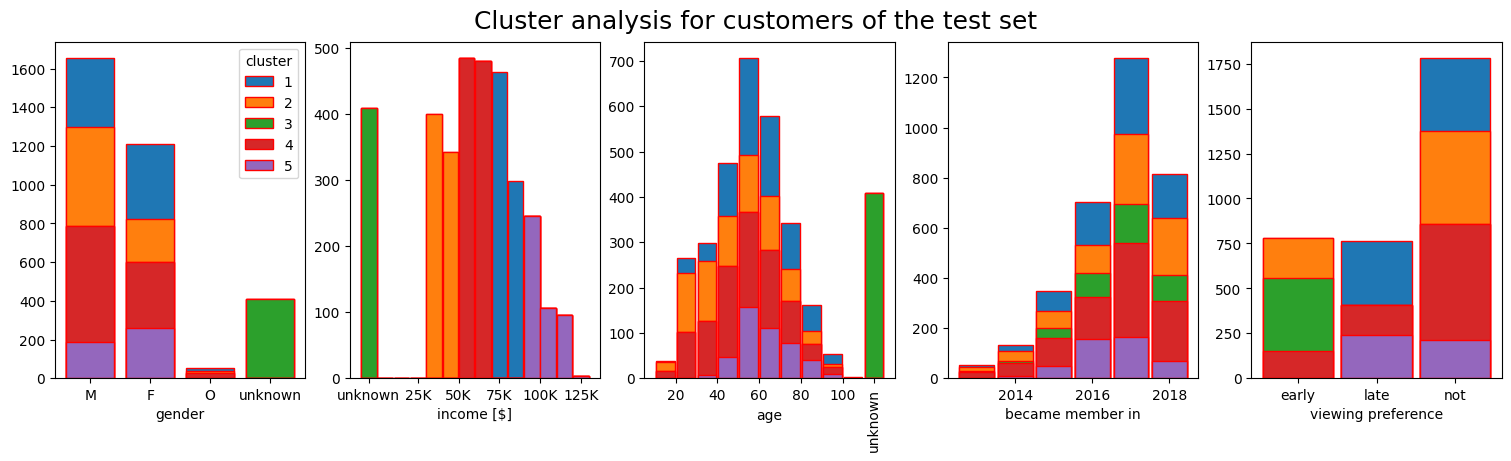

In [41]:
# Cluster analysis among the entire customers of the test set
offer_id=list(df_portfolio.sort_values(by=["offer_type","reward","difficulty","duration"],ascending=[True,False,False,False]).id)[0]
df_feat_targ_test=set1[(set1.offer_id==offer_id) | (set1.offer_id==offer_id + "no offer")].drop_duplicates(subset=["person"])[["gender_M", "gender_F", "gender_O", "gender_nan", "age", "became_member_on", "income", "early_viewing_pref","late_viewing_pref"]]

fig, axs= plt.subplots(1, 5,figsize=(15,4.5), layout='constrained', sharey=False)

income_step=10000
age_step=10

# title
fig.suptitle("Cluster analysis for customers of the test set" , fontsize=18)

# find the optimal number of clusters   
best_n_clusters=1 
sil_score_max = -1 # this is the minimum possible score
for n_clusters in range(2,min(6,df_feat_targ_test.shape[0]+1)):
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=1)
    
    labels = kmeans.fit_predict(df_feat_targ_test.values)
    if (n_clusters<df_feat_targ_test.shape[0]):   #Number of labels is XXXXX. Valid values are 2 to n_samples - 1 (inclusive)
        sil_score = silhouette_score(df_feat_targ_test.values, labels)
    else:
        sil_score=n_clusters
    if sil_score > sil_score_max:
        sil_score_max = sil_score
        best_n_clusters = n_clusters

kmeans=KMeans(n_clusters=best_n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=1)
    
# subplot 1 "gender")
if (df_feat_targ_test.shape[0]>1):
    kmeans.fit(df_feat_targ_test.values)
    bol_vec=(kmeans.labels_>=0) 
    for k in range(0,best_n_clusters):
        data=df_feat_targ_test[["gender_M", "gender_F", "gender_O", "gender_nan"]].loc[bol_vec].sum()
        axs[0].bar(["M","F","O","unknown"],data.values,edgecolor="red", label=str(k+1))# +", "+ str(round(round(a/b,3)*100,1)))
        bol_vec=bol_vec & (kmeans.labels_!=k)
axs[0].legend(title="cluster")
axs[0].set_xlabel('gender')


# subplot 2 "income")
keycol=[i for i in range(-10000,130000,income_step)]
if (df_feat_targ_test.shape[0]>1):
    bol_vec=(kmeans.labels_>=0) 
    for k in range(0,best_n_clusters):
        df_feat_targ_test_mod=df_feat_targ_test[["income"]].loc[bol_vec]
        
        countcol=[df_feat_targ_test_mod[df_feat_targ_test_mod.income==i].shape[0] for i in keycol]
        axs[1].bar(np.array(keycol)+income_step/2,countcol,edgecolor="red", width=income_step*0.95)
        bol_vec=bol_vec & (kmeans.labels_!=k)
axs[1].set_xlabel('income [$]')
axs[1].set_xticks([-income_step/2,25000,50000,75000,100000,125000])
axs[1].set_xticklabels(["unknown"]+list(['{:,.0f}'.format(x)+"K" for x in [i/1000 for i in axs[1].get_xticks()]][1:]))


# subplot 3 "age")
keycol=[i for i in range(10,120,age_step)]
if (df_feat_targ_test.shape[0]>1):
    bol_vec=(kmeans.labels_>=0) 
    for k in range(0,best_n_clusters):
        df_feat_targ_test_mod=df_feat_targ_test[["age"]].loc[bol_vec]
        countcol=[df_feat_targ_test_mod[df_feat_targ_test_mod.age==i].shape[0] for i in keycol]
        axs[2].bar(np.array(keycol)+age_step/2,countcol,edgecolor="red", width=9)
        bol_vec=bol_vec & (kmeans.labels_!=k)
axs[2].set_xlabel('age')
axs[2].xaxis.set_label_coords(0.5, -0.09)
axs[2].set_xticks([20,40,60,80,100,115])
axs[2].set_xticklabels(list([x for x in [i for i in axs[2].get_xticks()]][:-1])+["unknown"])
axs[2].get_xticklabels()[-1].set_rotation(90)

# subplot 4 "became member on")
keycol=[i for i in range(2013,2019,1)]
if (df_feat_targ_test.shape[0]>1):
    bol_vec=(kmeans.labels_>=0) 
    for k in range(0,best_n_clusters):
        df_feat_targ_test_mod=df_feat_targ_test[["became_member_on"]].loc[bol_vec]
        countcol=[df_feat_targ_test_mod[df_feat_targ_test_mod.became_member_on==i].shape[0] for i in keycol]
        axs[3].bar(keycol,countcol,edgecolor="red", width=0.9)
        bol_vec=bol_vec & (kmeans.labels_!=k)
axs[3].set_xlabel('became member in')

# subplot 5 "viewing_times"
if (df_feat_targ_test.shape[0]>1):
    kmeans.fit(df_feat_targ_test.values)
    bol_vec=(kmeans.labels_>=0) 
    for k in range(0,best_n_clusters):
        df_feat_targ_test_mod=df_feat_targ_test[["early_viewing_pref", "late_viewing_pref"]].loc[bol_vec].sum()
        df_feat_targ_test_mod["not_viewed"]=((df_feat_targ_test["early_viewing_pref"]==False) & (df_feat_targ_test["late_viewing_pref"]==False)).loc[bol_vec].sum()
        axs[4].bar(["early","late","not"],df_feat_targ_test_mod.values,edgecolor="red", width=0.9,label='# of persons')
        bol_vec=bol_vec & (kmeans.labels_!=k)
axs[4].set_xlabel('viewing preference')
plt.show()



## 5.5 Visualize customer profiles of customers to treat

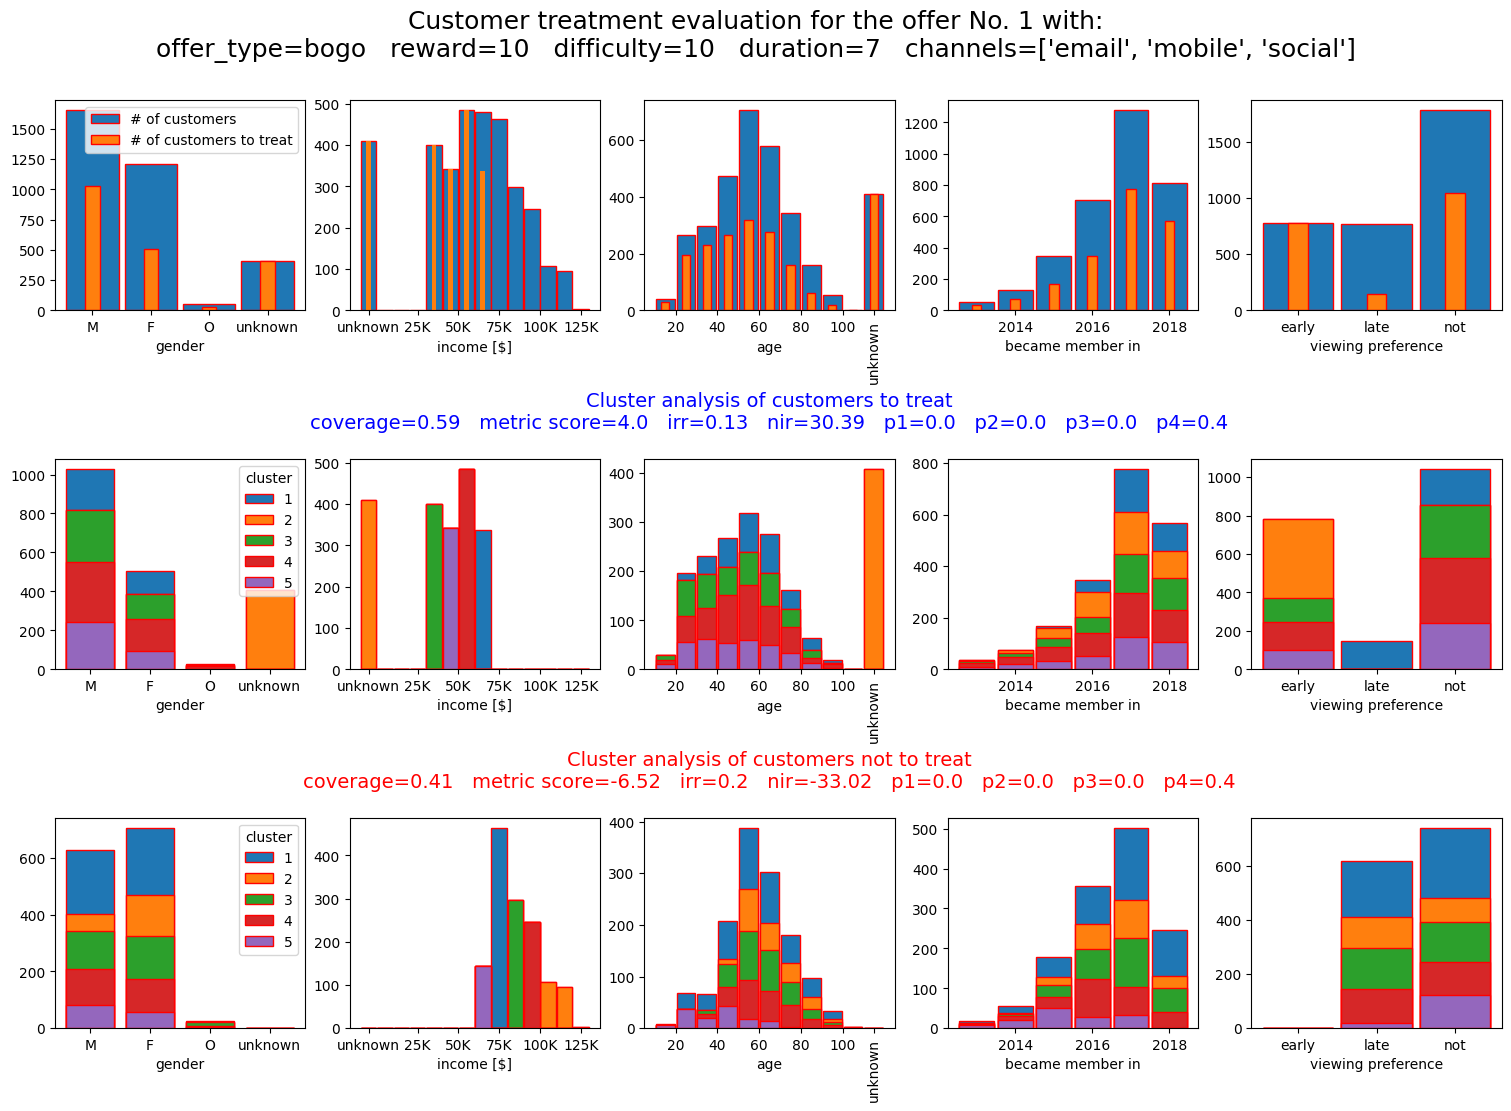

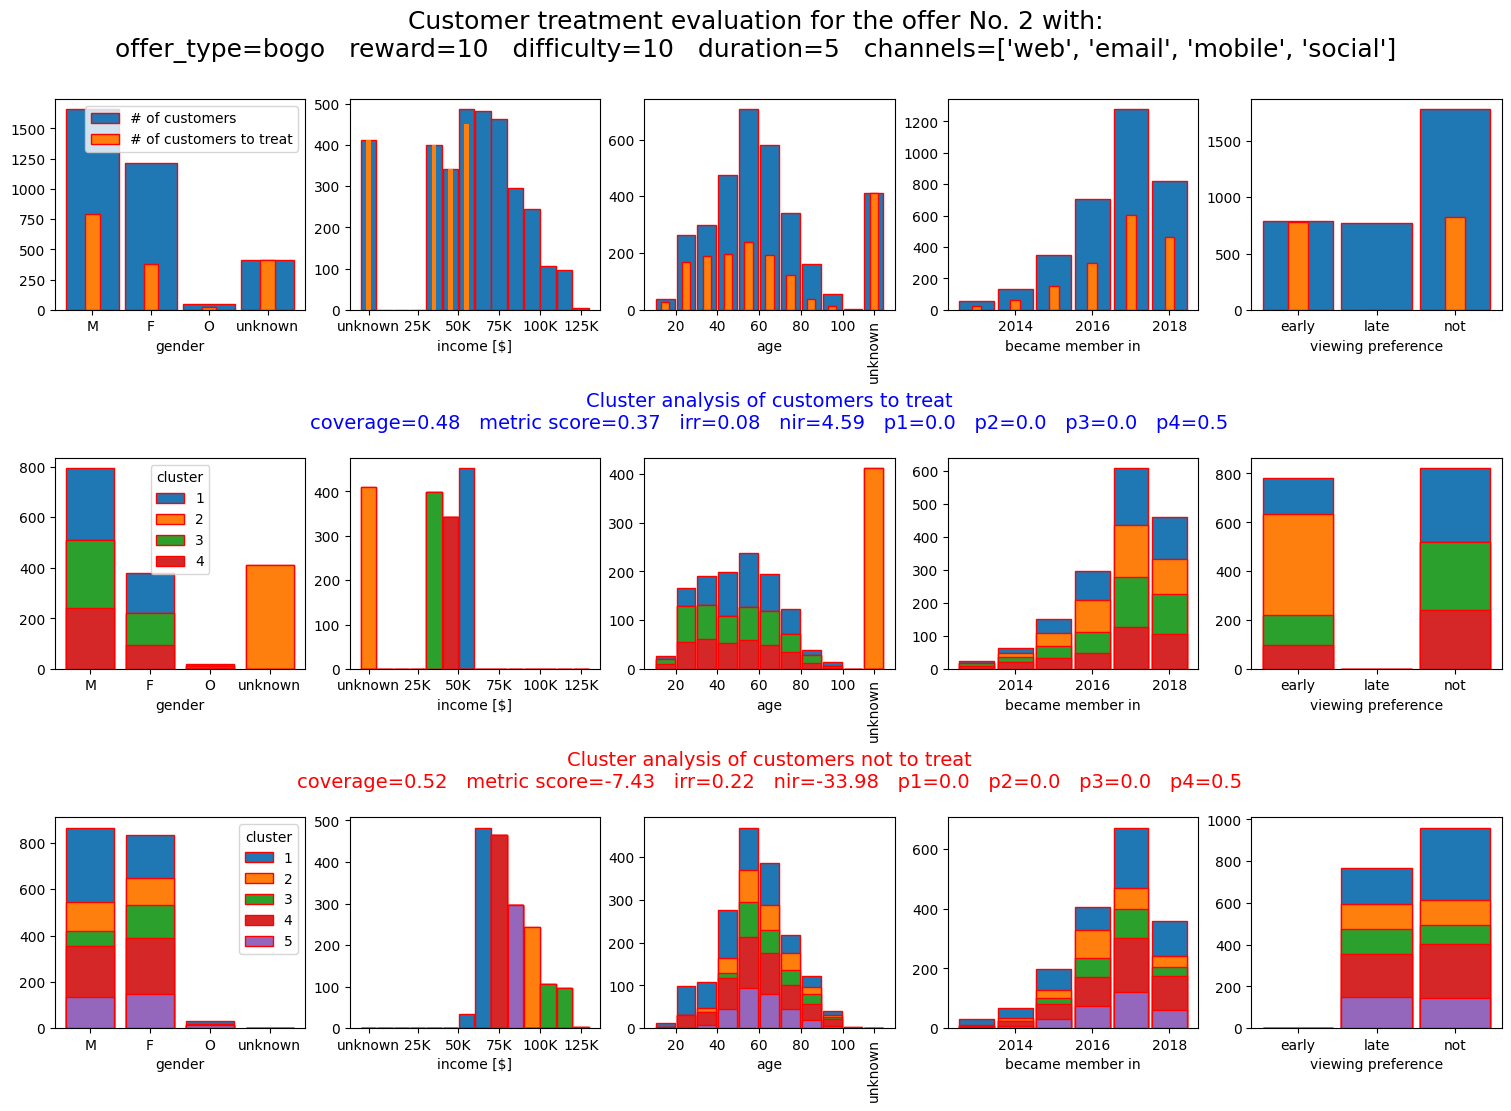

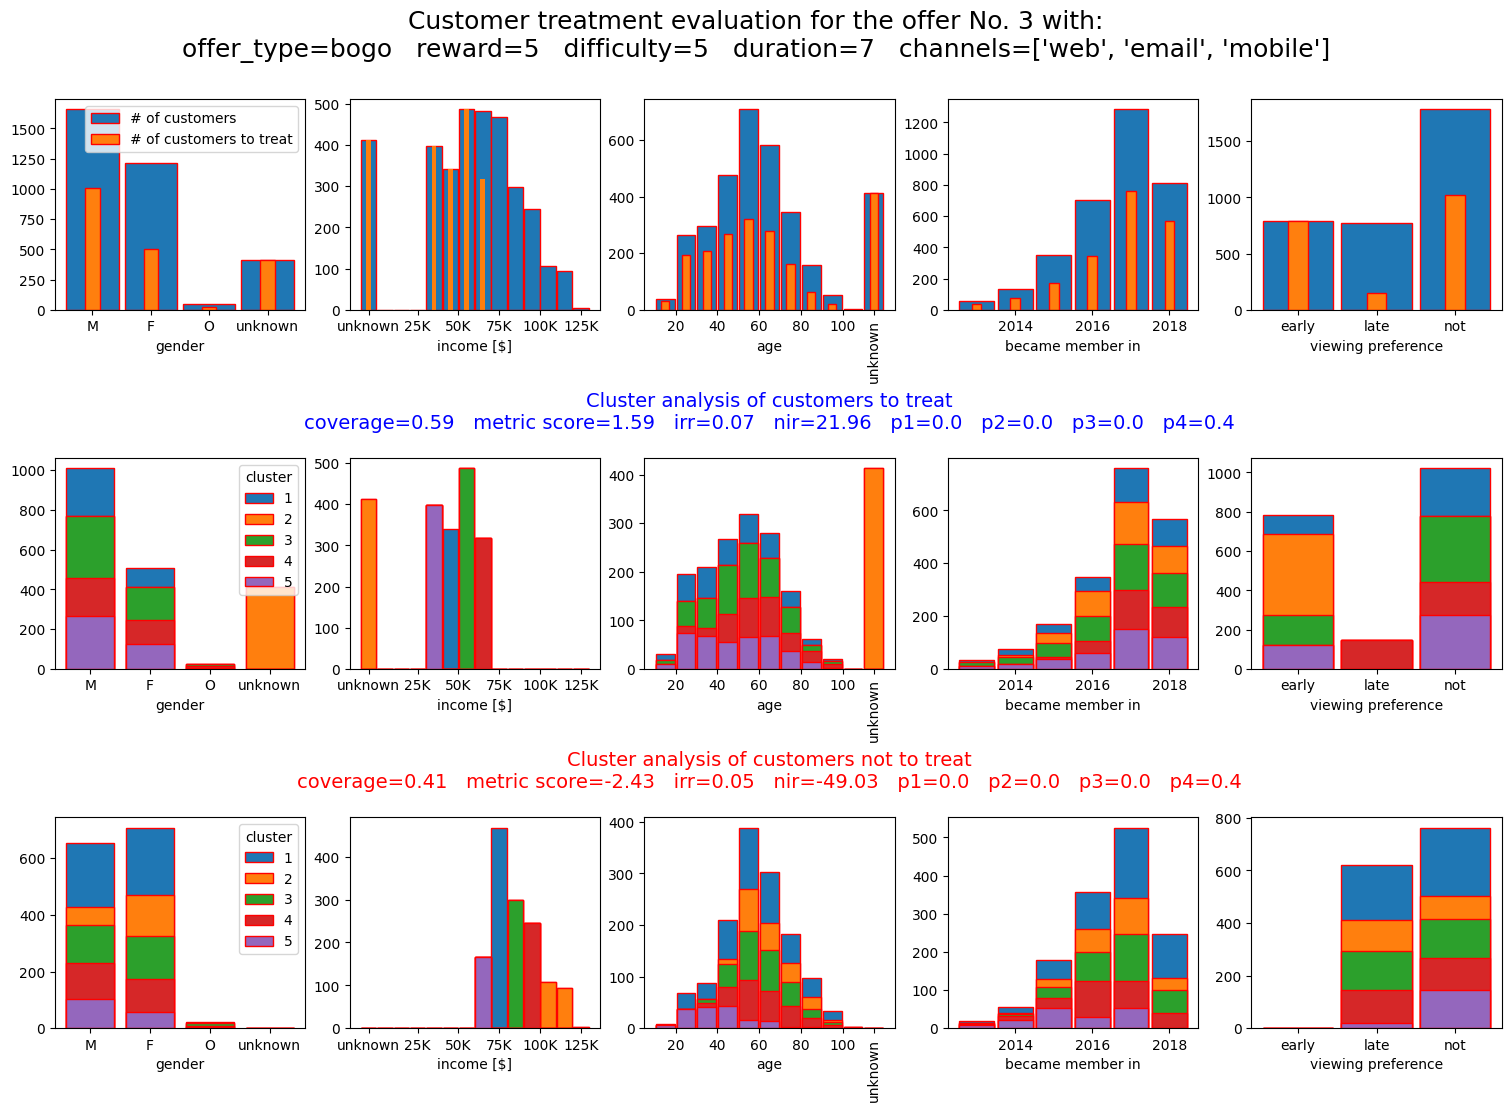

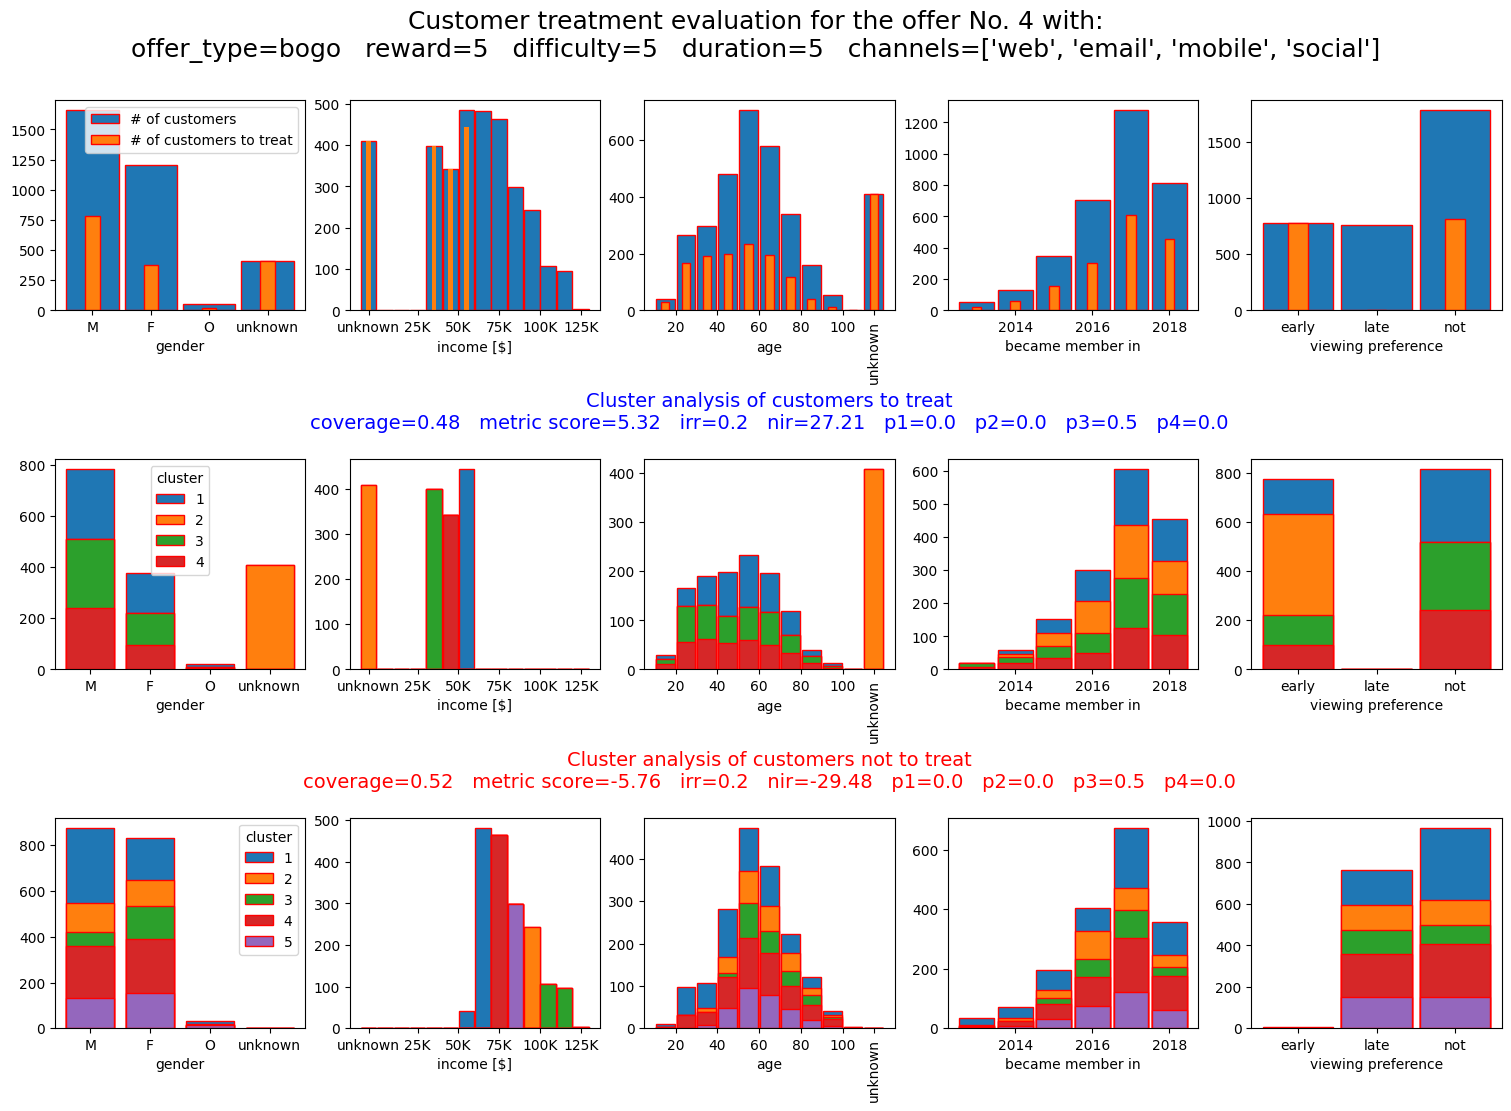

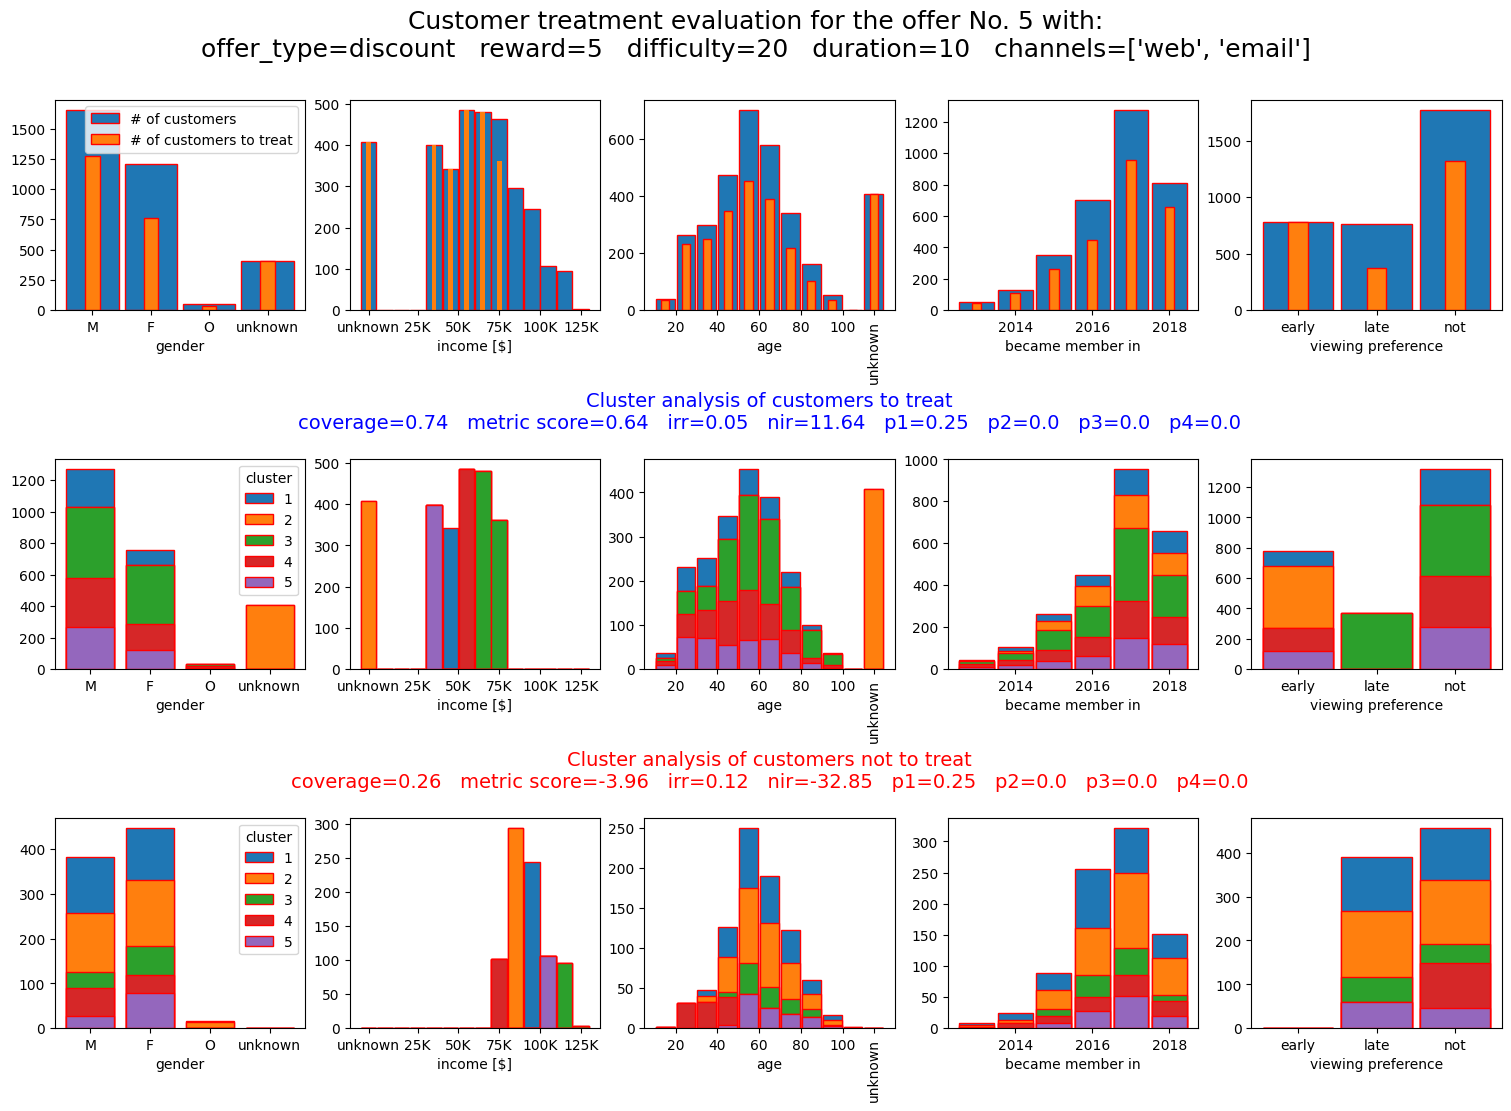

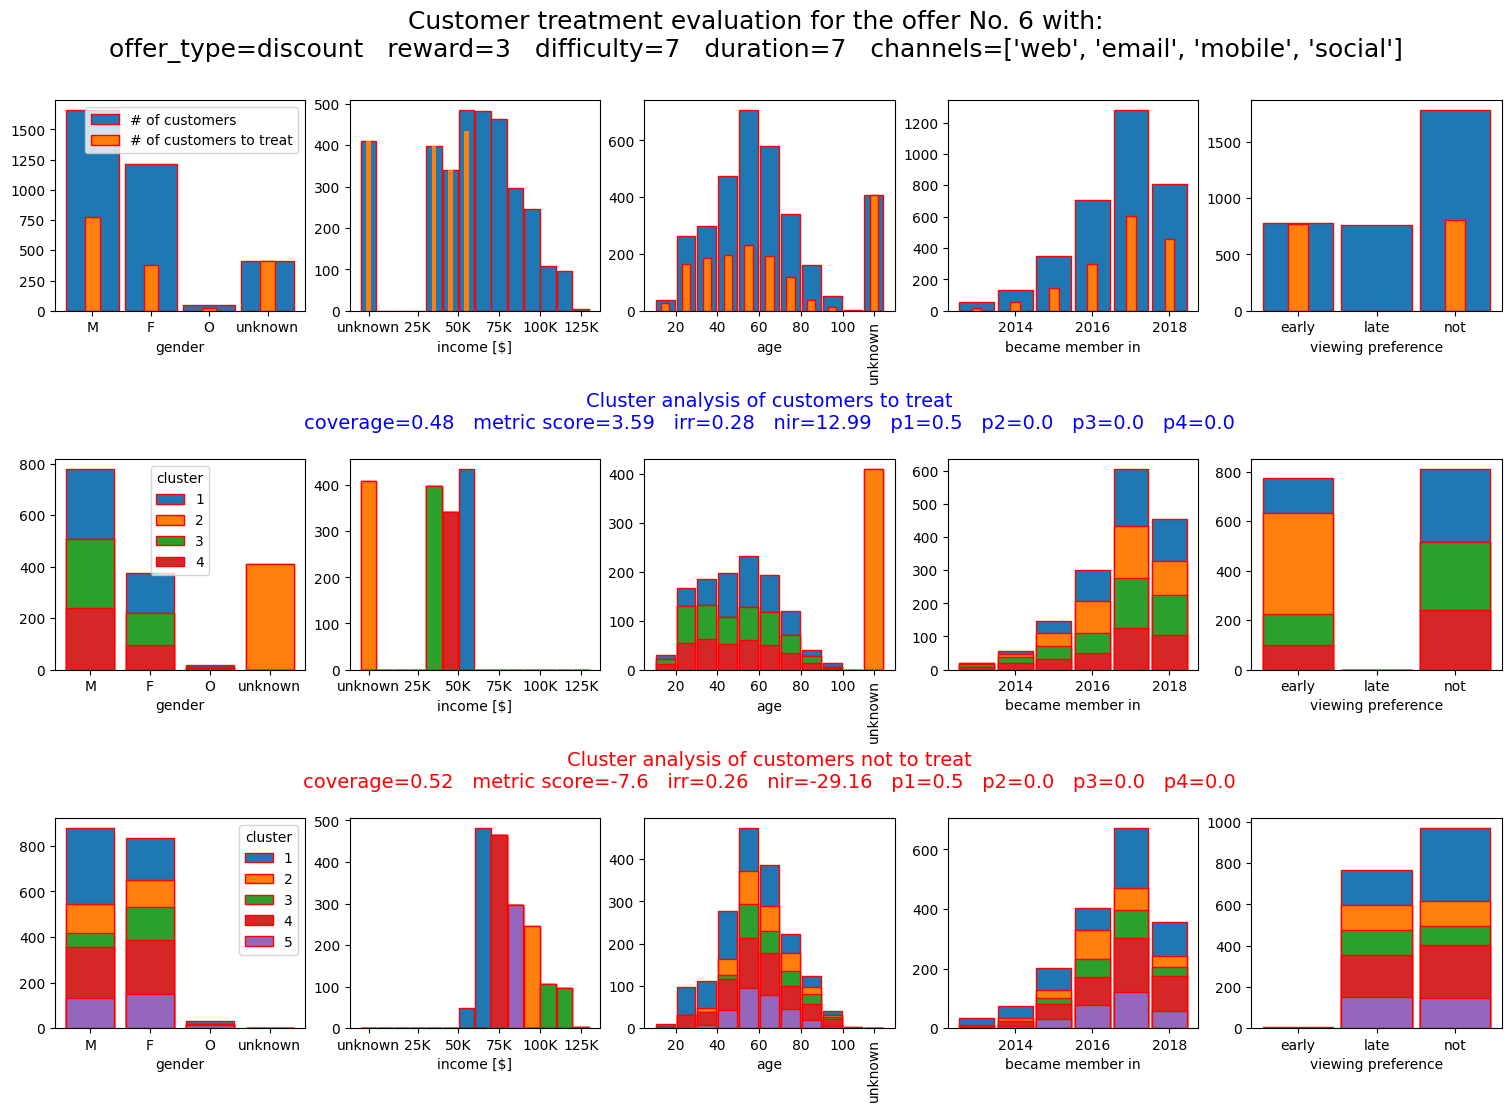

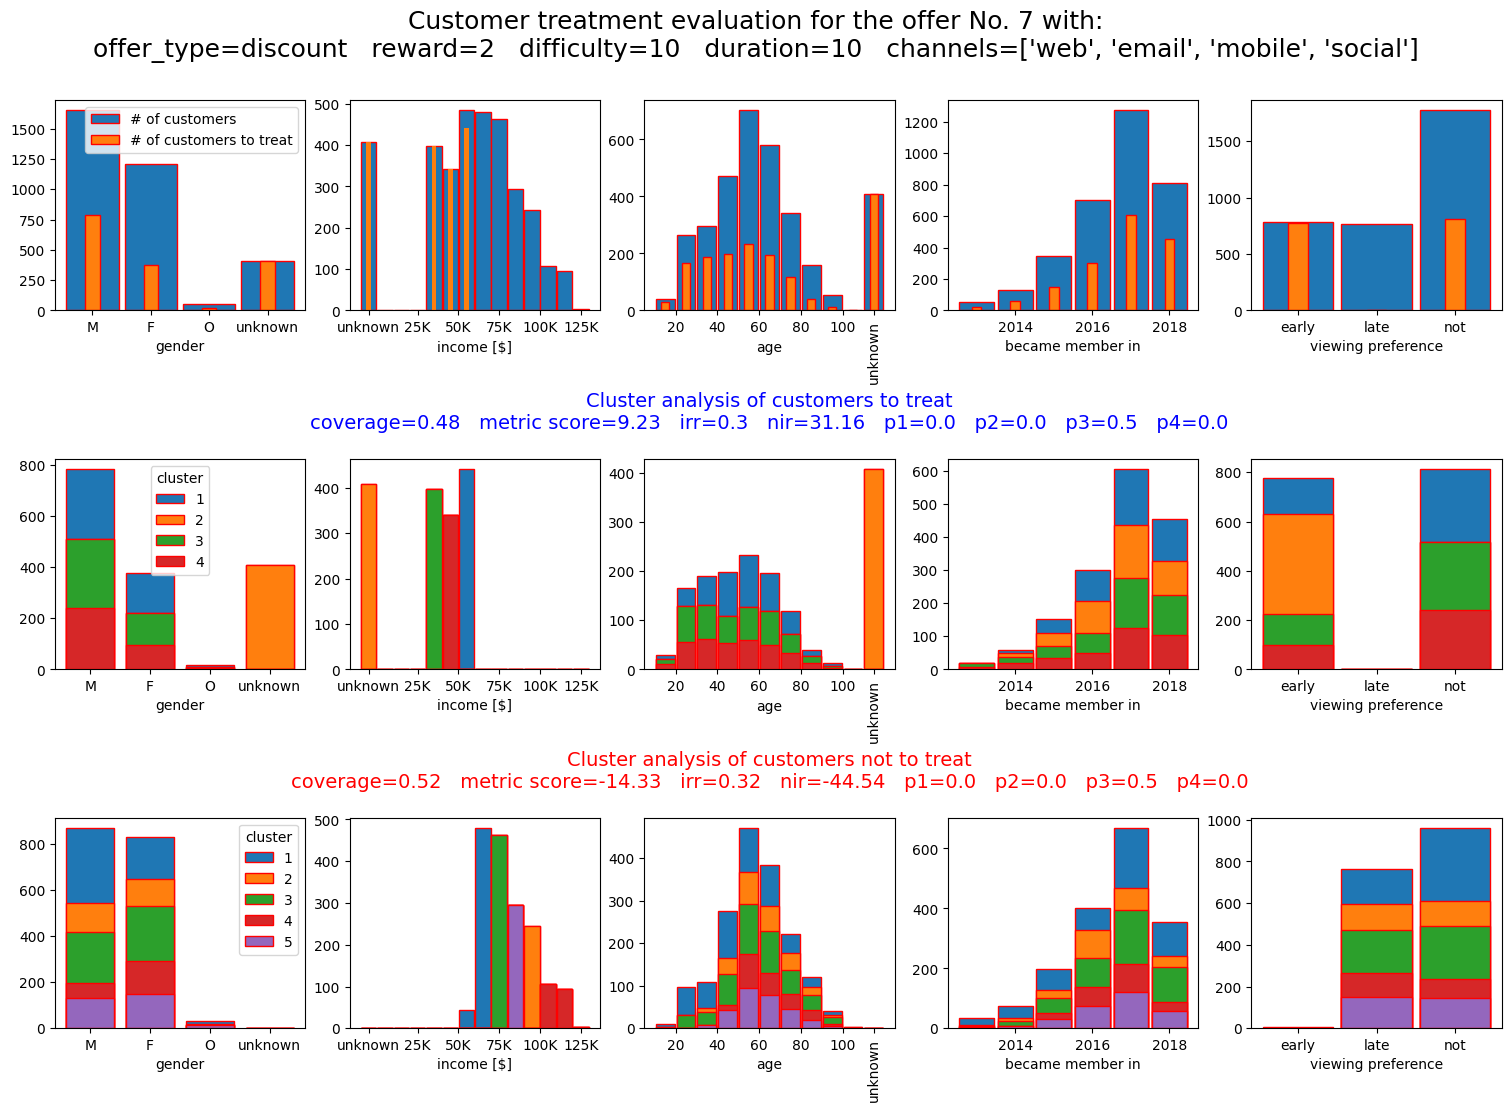

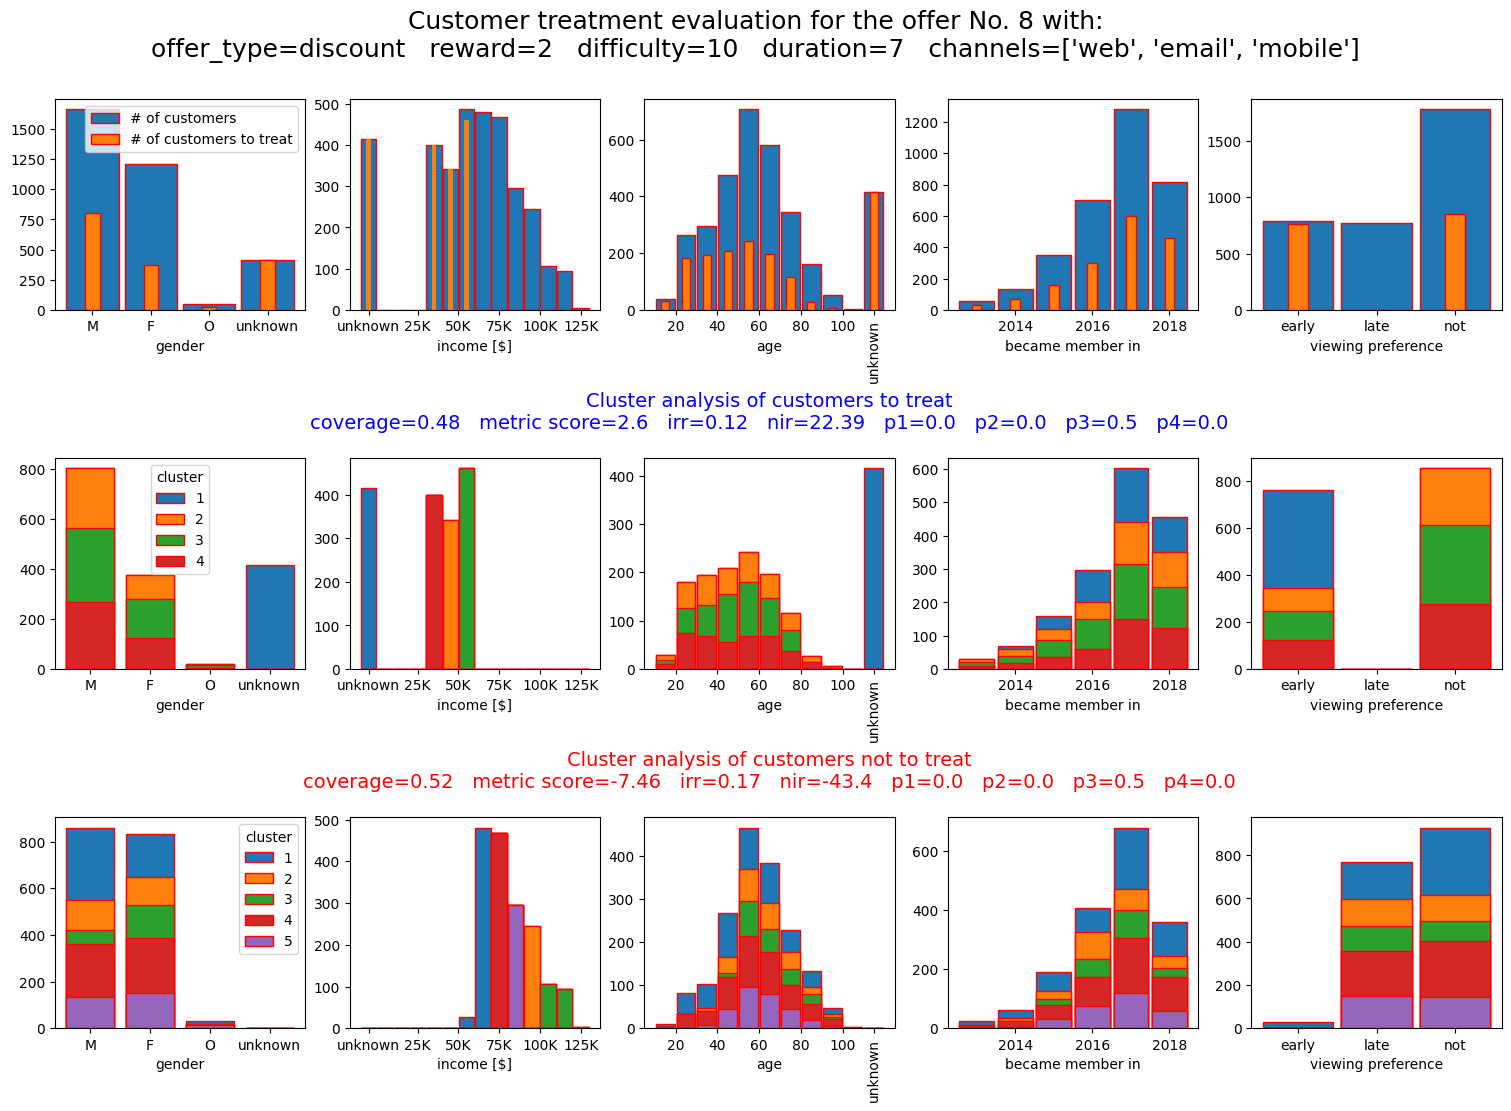

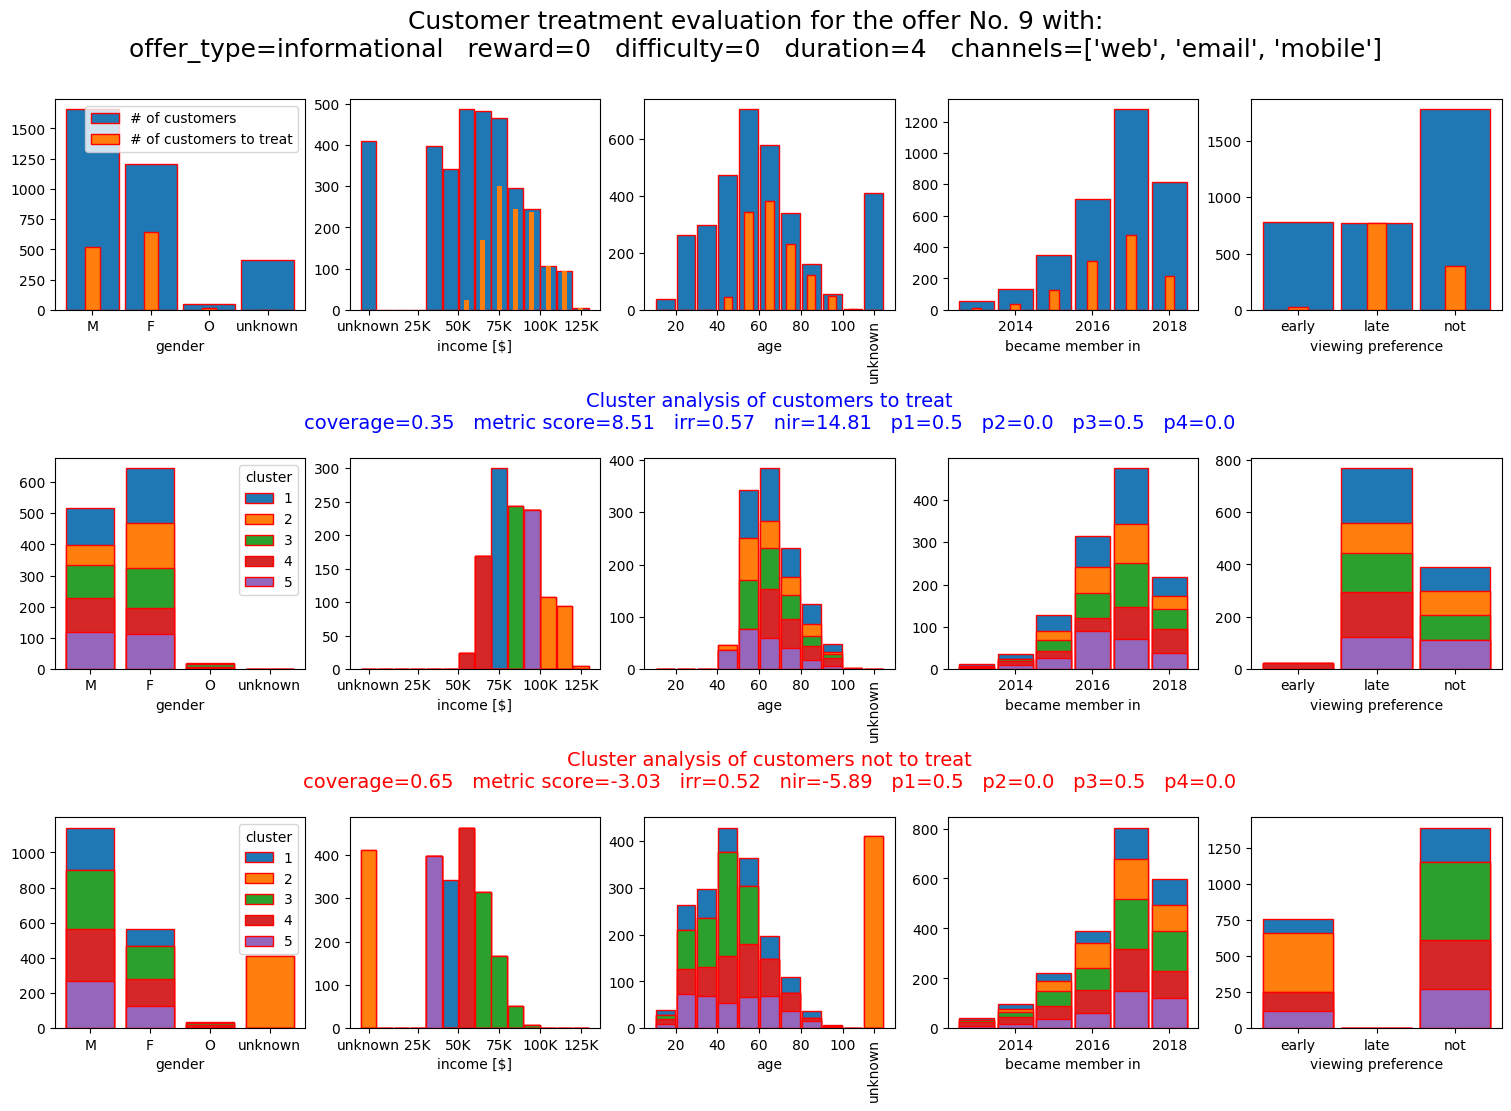

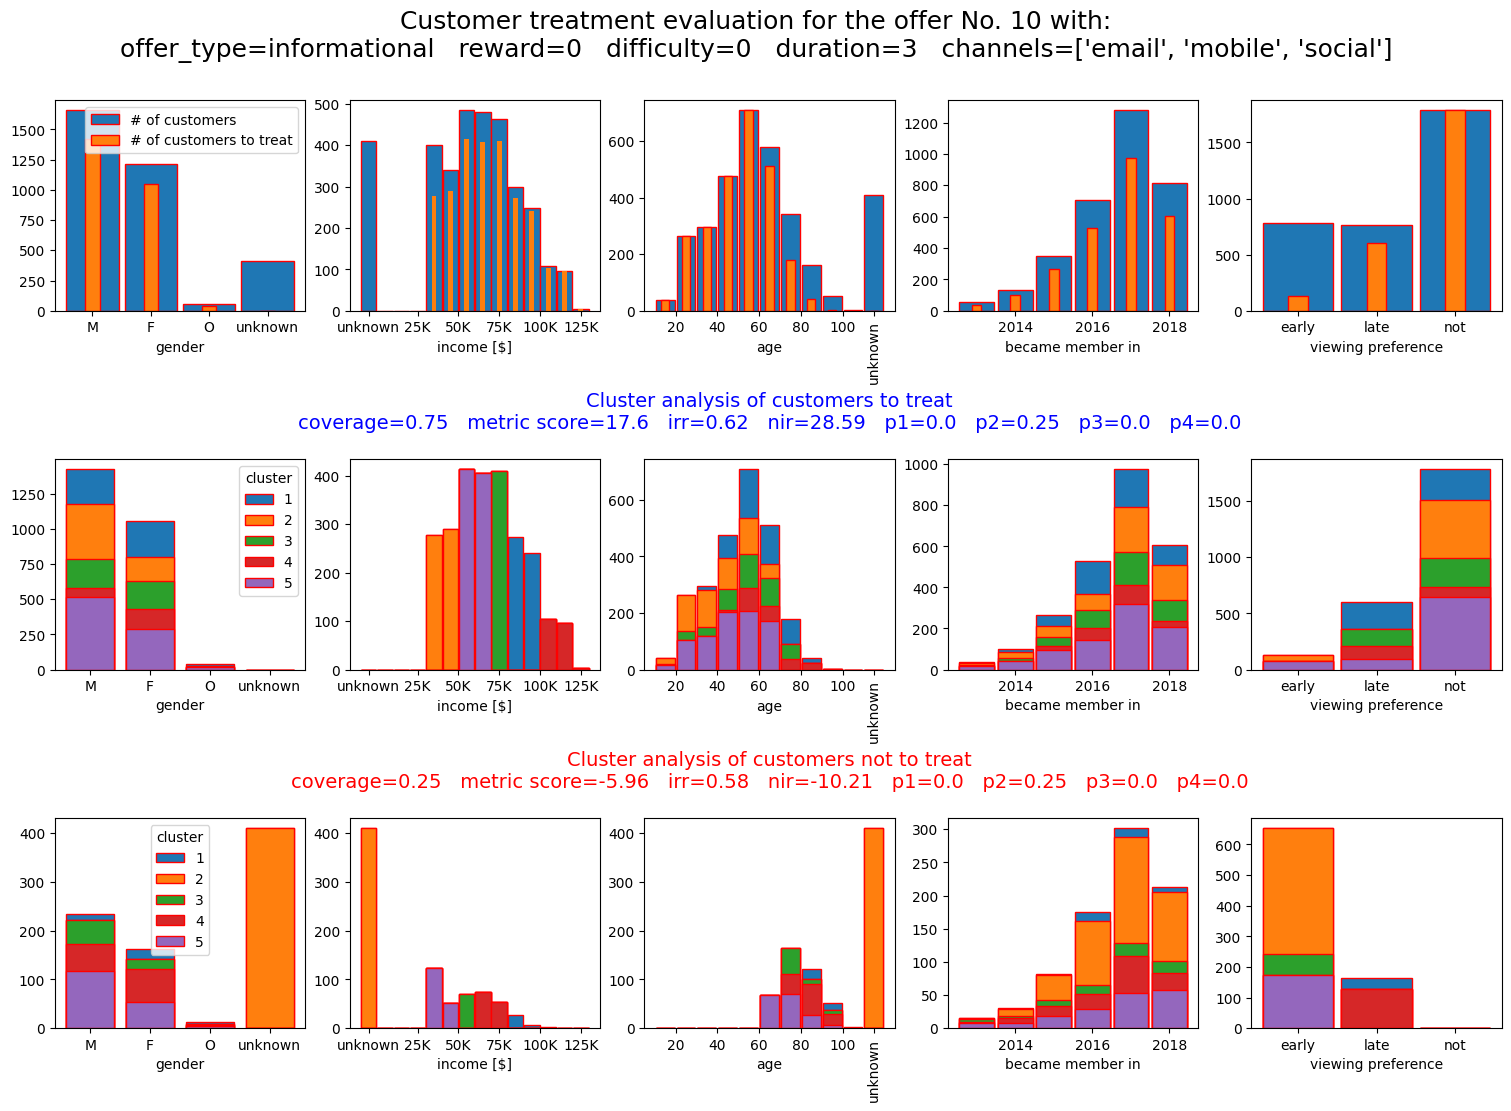

In [40]:
# loop offer_ids

offer_count=0
for offer_id in list(df_portfolio.sort_values(by=["offer_type","reward","difficulty","duration"],ascending=[True,False,False,False]).id):


    offer_count+=1

    df_feat_targ_test=set1[(set1.offer_id==offer_id) | (set1.offer_id==offer_id + "no offer")].drop_duplicates(subset=["person"])[["gender_M", "gender_F", "gender_O", "gender_nan", "age", "became_member_on", "income", "early_viewing_pref","late_viewing_pref"]]
    persons_to_promote=set2[(set2.offer_id==offer_id) | (set2.offer_id==offer_id + "no offer")].drop_duplicates(subset=["person"])[["gender_M", "gender_F", "gender_O", "gender_nan", "age", "became_member_on", "income", "early_viewing_pref","late_viewing_pref"]]
    persons_not_to_promote=set3[(set3.offer_id==offer_id) | (set3.offer_id==offer_id + "no offer")].drop_duplicates(subset=["person"])[["gender_M", "gender_F", "gender_O", "gender_nan", "age", "became_member_on", "income", "early_viewing_pref","late_viewing_pref"]]


    fig, axs= plt.subplots(3, 5,figsize=(15,11), layout='constrained', sharey=False)

    income_step=10000
    age_step=10

    
    # title
    tmp=df_portfolio[df_portfolio.id==offer_id][["offer_type", "reward", "difficulty", "duration", "channels"]]
    cols=list(tmp.keys())
    vals=list(tmp.values[0])
    fig.suptitle("Customer treatment evaluation for the offer No. "+str(offer_count)+" with:"+ "\n"+"   ".join([cols[i] +"=" + str(vals[i]) for i in range(len(cols))])+"\n" , fontsize=18)


    # subplot 1,1 "gender"
    data=df_feat_targ_test[["gender_M", "gender_F", "gender_O", "gender_nan"]].sum()
    axs[0,0].bar(["M","F","O","unknown"],data.values,edgecolor="red", width=0.9,label='# of customers')
    data=persons_to_promote[["gender_M", "gender_F", "gender_O", "gender_nan"]].sum()
    axs[0,0].bar(["M","F","O","unknown"],data.values,edgecolor="red", width=0.25, label='# of customers to treat')
    axs[0,0].legend()
    axs[0,0].set_xlabel('gender')
    

    # subplot 1,2 "income"  
    keycol=[i for i in range(-10000,130000,income_step)]
    countcol=[df_feat_targ_test[["income"]][df_feat_targ_test.income==i].count().values[0] for i in keycol]
    axs[0,1].bar(np.array(keycol)+income_step/2,countcol,edgecolor="red", width=income_step*0.95)
    countcol=[persons_to_promote[["income"]][persons_to_promote.income==i].count().values[0] for i in keycol]
    axs[0,1].bar(np.array(keycol)+income_step/2,countcol, width=income_step*0.3)
    axs[0,1].set_xlabel('income [$]')
    axs[0,1].set_xticks([-income_step/2,25000,50000,75000,100000,125000])
    axs[0,1].set_xticklabels(["unknown"]+list(['{:,.0f}'.format(x)+"K" for x in [i/1000 for i in axs[0,1].get_xticks()]][1:]))
    
    # subplot 1,3 "age"
    keycol=[i for i in range(10,120,age_step)]
    countcol=[df_feat_targ_test[["age"]][df_feat_targ_test.age==i].count().values[0] for i in keycol]
    axs[0,2].bar(np.array(keycol)+age_step/2,countcol,edgecolor="red", width=9)
    countcol=[persons_to_promote[["age"]][persons_to_promote.age==i].count().values[0] for i in keycol]
    axs[0,2].bar(np.array(keycol)+age_step/2,countcol,edgecolor="red", width=4)
    axs[0,2].set_xlabel('age')
    axs[0,2].xaxis.set_label_coords(0.5, -0.14)
    axs[0,2].set_xticks([20,40,60,80,100,115])
    axs[0,2].set_xticklabels(list([x for x in [i for i in axs[0,2].get_xticks()]][:-1])+["unknown"])
    axs[0,2].get_xticklabels()[-1].set_rotation(90)
    
        
    # subplot 1,4 "became_member_on"
    keycol=[i for i in range(2013,2019,1)]
    countcol=[df_feat_targ_test[["became_member_on"]][df_feat_targ_test.became_member_on==i].count().values[0] for i in keycol]
    axs[0,3].bar(keycol,countcol,edgecolor="red", width=0.9)
    countcol=[persons_to_promote[["became_member_on"]][persons_to_promote.became_member_on==i].count().values[0] for i in keycol]
    axs[0,3].bar(keycol,countcol,edgecolor="red", width=0.25)
    axs[0,3].set_xlabel('became member in')

    # subplot 1,5 "viewing_times"
    data=df_feat_targ_test[["early_viewing_pref","late_viewing_pref"]].sum()
    data["not_viewed"]=((df_feat_targ_test["early_viewing_pref"]==False) & (df_feat_targ_test["late_viewing_pref"]==False)).sum()
    axs[0,4].bar(["early","late","not"],data.values,edgecolor="red", width=0.9,label='# of persons')
    data=persons_to_promote[["early_viewing_pref","late_viewing_pref"]].sum()
    data["not_viewed"]=((persons_to_promote["early_viewing_pref"]==False) & (persons_to_promote["late_viewing_pref"]==False)).sum()
    axs[0,4].bar(["early","late","not"],data.values,edgecolor="red", width=0.25, label='# of customers to treat')
    axs[0,4].set_xlabel('viewing preference')

    # find the optimal number of clusters   
    best_n_clusters=1 
    sil_score_max = -1 # this is the minimum possible score
    for n_clusters in range(2,min(6,persons_to_promote.shape[0]+1)):
        kmeans = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=1)
        labels = kmeans.fit_predict(persons_to_promote.values)
        n_labels=len(pd.Series(labels).unique())
        if ((n_clusters<persons_to_promote.shape[0])&(n_labels>1)):   
            sil_score = silhouette_score(persons_to_promote.values, labels)
        else:
            sil_score=n_clusters if n_labels>1 else -1
        if sil_score > sil_score_max:
            sil_score_max = sil_score
            best_n_clusters = n_clusters
    
    kmeans=KMeans(n_clusters=best_n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=1)
      
    # subplot 2,1 "gender")
    if (persons_to_promote.shape[0]>1):
        kmeans.fit(persons_to_promote.values)
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            data=persons_to_promote[["gender_M", "gender_F", "gender_O", "gender_nan"]].loc[bol_vec].sum()
            axs[1,0].bar(["M","F","O","unknown"],data.values,edgecolor="red", label=str(k+1))
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[1,0].legend(title="cluster")
    axs[1,0].set_xlabel('gender')
    
  
    # subplot 2,2 "income")
    keycol=[i for i in range(-10000,130000,income_step)]
    if (persons_to_promote.shape[0]>1):
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_to_promote_mod=persons_to_promote[["income"]].loc[bol_vec]
            
            countcol=[persons_to_promote_mod[persons_to_promote_mod.income==i].shape[0] for i in keycol]
            axs[1,1].bar(np.array(keycol)+income_step/2,countcol,edgecolor="red", width=income_step*0.95)
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[1,1].set_xlabel('income [$]')
    axs[1,1].set_xticks([-income_step/2,25000,50000,75000,100000,125000])
    axs[1,1].set_xticklabels(["unknown"]+list(['{:,.0f}'.format(x)+"K" for x in [i/1000 for i in axs[1,1].get_xticks()]][1:]))


    # subplot 2,3 "age")
    keycol=[i for i in range(10,120,age_step)]
    if (persons_to_promote.shape[0]>1):
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_to_promote_mod=persons_to_promote[["age"]].loc[bol_vec]
            countcol=[persons_to_promote_mod[persons_to_promote_mod.age==i].shape[0] for i in keycol]
            axs[1,2].bar(np.array(keycol)+age_step/2,countcol,edgecolor="red", width=9)
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[1,2].set_xlabel('age')
    axs[1,2].xaxis.set_label_coords(0.5, -0.14)
    axs[1,2].set_xticks([20,40,60,80,100,115])
    axs[1,2].set_xticklabels(list([x for x in [i for i in axs[1,2].get_xticks()]][:-1])+["unknown"])
    axs[1,2].get_xticklabels()[-1].set_rotation(90)
    # axs[1,2].set_title("\n       Cluster analysis of customers to treat for offer No. "+str(offer_count)+"       \n",fontsize=18)
    # axs[1,2].set_title("Cluster analysis of customers to treat\n"+"metric score="+str(round(float(main_score_dict[offer_id]),4))+"   "+"irr="+str(round(float(irr_dict[offer_id]),4))+"   "+"nir="+str(round(float(nir_dict[offer_id]),4)) +"   "+"p1="+str(round(float(prob_threshold1__dict[offer_id]),4))  +"   "+"p2="+str(round(float(prob_threshold2__dict[offer_id]),4))  +"   "+"p3="+str(round(float(prob_threshold3__dict[offer_id]),4))  +"   "+"p4="+str(round(float(prob_threshold4__dict[offer_id]),4))  +"\n",fontsize=14, color="blue" if main_score_dict[offer_id]>0 else "red")

    axs[1,2].set_title("Cluster analysis of customers to treat\n" + "coverage=" +  str(round(persons_to_promote.shape[0]/df_feat_targ_test.shape[0],2) )  +"   "+ "metric score="+str(round(float(main_score_dict[offer_id]),2))+"   "+"irr="+str(round(float(irr_dict[offer_id]),2))+"   "+"nir="+str(round(float(nir_dict[offer_id]),2)) +"   "+"p1="+str(round(float(prob_threshold1__dict[offer_id]),2))  +"   "+"p2="+str(round(float(prob_threshold2__dict[offer_id]),2))  +"   "+"p3="+str(round(float(prob_threshold3__dict[offer_id]),2))  +"   "+"p4="+str(round(float(prob_threshold4__dict[offer_id]),2))  +"\n",fontsize=14, color="blue" if main_score_dict[offer_id]>0 else "red")

    # subplot 2,4 "became_member_on")
    keycol=[i for i in range(2013,2019,1)]
    if (persons_to_promote.shape[0]>1):
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_to_promote_mod=persons_to_promote[["became_member_on"]].loc[bol_vec]
            countcol=[persons_to_promote_mod[persons_to_promote_mod.became_member_on==i].shape[0] for i in keycol]
            axs[1,3].bar(keycol,countcol,edgecolor="red", width=0.9)
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[1,3].set_xlabel('became member in')

    # subplot 2,5 "viewing_times"
    if (persons_to_promote.shape[0]>1):
        kmeans.fit(persons_to_promote.values)
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_to_promote_mod=persons_to_promote[["early_viewing_pref", "late_viewing_pref"]].loc[bol_vec].sum()
            persons_to_promote_mod["not_viewed"]=((persons_to_promote["early_viewing_pref"]==False) & (persons_to_promote["late_viewing_pref"]==False)).loc[bol_vec].sum()
            axs[1,4].bar(["early","late","not"],persons_to_promote_mod.values,edgecolor="red", width=0.9,label='# of persons')
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[1,4].set_xlabel('viewing preference')


    # find the optimal number of clusters   
    best_n_clusters=1 
    sil_score_max = -1 # this is the minimum possible score
    for n_clusters in range(2,min(6,persons_not_to_promote.shape[0]+1)):
        kmeans = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=1)
        labels = kmeans.fit_predict(persons_not_to_promote.values)
        n_labels=len(pd.Series(labels).unique())
        if ((n_clusters<persons_not_to_promote.shape[0])&(n_labels>1)):   
            sil_score = silhouette_score(persons_not_to_promote.values, labels)
        else:
            sil_score=n_clusters if n_labels>1 else -1
        if sil_score > sil_score_max:
            sil_score_max = sil_score
            best_n_clusters = n_clusters
    
    kmeans=KMeans(n_clusters=best_n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=1)

    # subplot 3,1 "gender")
    if (persons_not_to_promote.shape[0]>1):
        kmeans.fit(persons_not_to_promote.values)
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            data=persons_not_to_promote[["gender_M", "gender_F", "gender_O", "gender_nan"]].loc[bol_vec].sum()
            axs[2,0].bar(["M","F","O","unknown"],data.values,edgecolor="red", label=str(k+1))
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[2,0].legend(title="cluster")
    axs[2,0].set_xlabel('gender')
    
  
    # subplot 3,2 "income")
    keycol=[i for i in range(-10000,130000,income_step)]
    if (persons_not_to_promote.shape[0]>1):
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_not_to_promote_mod=persons_not_to_promote[["income"]].loc[bol_vec]
            
            countcol=[persons_not_to_promote_mod[persons_not_to_promote_mod.income==i].shape[0] for i in keycol]
            axs[2,1].bar(np.array(keycol)+income_step/2,countcol,edgecolor="red", width=income_step*0.95)
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[2,1].set_xlabel('income [$]')
    axs[2,1].set_xticks([-income_step/2,25000,50000,75000,100000,125000])
    axs[2,1].set_xticklabels(["unknown"]+list(['{:,.0f}'.format(x)+"K" for x in [i/1000 for i in axs[1,1].get_xticks()]][1:]))


    # subplot 3,3 "age")
    keycol=[i for i in range(10,120,age_step)]
    if (persons_not_to_promote.shape[0]>1):
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_not_to_promote_mod=persons_not_to_promote[["age"]].loc[bol_vec]
            countcol=[persons_not_to_promote_mod[persons_not_to_promote_mod.age==i].shape[0] for i in keycol]
            axs[2,2].bar(np.array(keycol)+age_step/2,countcol,edgecolor="red", width=9)
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[2,2].set_xlabel('age')
    axs[2,2].xaxis.set_label_coords(0.5, -0.14)
    axs[2,2].set_xticks([20,40,60,80,100,115])
    axs[2,2].set_xticklabels(list([x for x in [i for i in axs[1,2].get_xticks()]][:-1])+["unknown"])
    axs[2,2].get_xticklabels()[-1].set_rotation(90)
    axs[2,2].set_title( "Cluster analysis of customers not to treat\n" + "coverage=" +  str(round((100-round(persons_to_promote.shape[0]/df_feat_targ_test.shape[0]*100,0))/100.0,2 ) ) +"   "+"metric score="+str(round(float(main_score_dict_not_to_prom[offer_id]),2))+"   "+"irr="+str(round(float(irr_dict_not_to_prom[offer_id]),2))+"   "+"nir="+str(round(float(nir_dict_not_to_prom[offer_id]),2)) +"   "+"p1="+str(round(float(prob_threshold1__dict[offer_id]),2))  +"   "+"p2="+str(round(float(prob_threshold2__dict[offer_id]),2))  +"   "+"p3="+str(round(float(prob_threshold3__dict[offer_id]),2))  +"   "+"p4="+str(round(float(prob_threshold4__dict[offer_id]),2))  +"\n",fontsize=14, color="blue" if main_score_dict_not_to_prom[offer_id]>0 else "red")

    # subplot 3,4 "became_member_on")
    keycol=[i for i in range(2013,2019,1)]
    if (persons_not_to_promote.shape[0]>1):
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_not_to_promote_mod=persons_not_to_promote[["became_member_on"]].loc[bol_vec]
            countcol=[persons_not_to_promote_mod[persons_not_to_promote_mod.became_member_on==i].shape[0] for i in keycol]
            axs[2,3].bar(keycol,countcol,edgecolor="red", width=0.9)
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[2,3].set_xlabel('became member in')

    # subplot 3,5 "viewing_times"
    if (persons_not_to_promote.shape[0]>1):
        kmeans.fit(persons_not_to_promote.values)
        bol_vec=(kmeans.labels_>=0) 
        for k in range(0,best_n_clusters):
            persons_not_to_promote_mod=persons_not_to_promote[["early_viewing_pref", "late_viewing_pref"]].loc[bol_vec].sum()
            persons_not_to_promote_mod["not_viewed"]=((persons_not_to_promote["early_viewing_pref"]==False) & (persons_not_to_promote["late_viewing_pref"]==False)).loc[bol_vec].sum()
            axs[2,4].bar(["early","late","not"],persons_not_to_promote_mod.values,edgecolor="red", width=0.9,label='# of persons')
            bol_vec=bol_vec & (kmeans.labels_!=k)
    axs[2,4].set_xlabel('viewing preference')


    plt.show()
